In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

%matplotlib inline
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model

import scipy
import sklearn

sns.set(color_codes=True)

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base

import os
import sys
sys.path.append("/home/verena/deployment/interpretable-audio-models/iml_methods/influence-release/")
from influence.binaryLogisticRegressionWithLBFGS import BinaryLogisticRegressionWithLBFGS
from influence.smooth_hinge import SmoothHinge
import influence.dataset as dataset
from influence.dataset import DataSet
#from binaryLogisticRegressionWithLBFGS import BinaryLogisticRegressionWithLBFGS
#from smooth_hinge import SmoothHinge
#import dataset as dataset
#from dataset import DataSet

np.random.seed(42)

Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
def examine_vec(x, verbose=False):
    assert len(feature_names) == len(x)
    print('Age: %s' % x[age_var_indices])
    if verbose:
        for feature_name, val in zip(feature_names, x):
            print('%32s: %.6f' % (feature_name, val))
    
def examine_train_point(idx, verbose=False):
    print('Label: %s' % Y_train[idx])
    examine_vec(modified_X_train[idx, :], verbose)
    
def examine_test_point(idx, verbose=False):
    print('Label: %s' % Y_test[idx])
    examine_vec(X_test[idx, :], verbose)

# Read and process dataset

In [4]:
df = pd.read_csv('/home/verena/experiments/influence/diabetic_data.csv') # TODO: dynamic path
# Use this if you are not running this in CodaLab
# df = pd.read_csv('../data/diabetic_data.csv')

In [5]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
# Convert categorical variables into numeric ones

X = pd.DataFrame()

# Numerical variables that we can pull directly
X = df.loc[:,  
    [
        'time_in_hospital',
        'num_lab_procedures',
        'num_procedures',
        'num_medications',
        'number_outpatient',
        'number_emergency',
        'number_inpatient',
        'number_diagnoses'
    ]]

categorical_var_names = [
    'gender',
    'race',
    'age', 
    'discharge_disposition_id',
    'max_glu_serum',
    'A1Cresult',
    'metformin',
    'repaglinide',
    'nateglinide',
    'chlorpropamide',
    'glimepiride',
    'acetohexamide',
    'glipizide',
    'glyburide',
    'tolbutamide',
    'pioglitazone',
    'rosiglitazone',
    'acarbose',
    'miglitol',
    'troglitazone',
    'tolazamide',
    'examide',
    'citoglipton',
    'insulin',
    'glyburide-metformin',
    'glipizide-metformin',
    'glimepiride-pioglitazone',
    'metformin-rosiglitazone',
    'metformin-pioglitazone',
    'change',
    'diabetesMed'
]

for categorical_var_name in categorical_var_names:
    categorical_var = pd.Categorical(
        df.loc[:, categorical_var_name])
    
    # Just have one dummy variable if it's boolean
    if len(categorical_var.categories) == 2:
        drop_first = True
    else:
        drop_first = False

    dummies = pd.get_dummies(
        categorical_var, 
        prefix=categorical_var_name,
        drop_first=drop_first)
    
    X = pd.concat([X, dummies], axis=1)

In [7]:
### Set the Y labels
readmitted = pd.Categorical(df.readmitted)

Y = np.copy(readmitted.codes)

# Combine >30 and 0 and flip labels, so 1 (>30) and 2 (No) become -1, while 0 becomes 1
Y[Y >= 1] = -1
Y[Y == 0] = 1

# Map to feature names
feature_names = X.columns.values

### Find indices of age features
age_var = pd.Categorical(df.loc[:, 'age'])
age_var_names = ['age_%s' % age_var_name for age_var_name in age_var.categories]    
age_var_indices = []
for age_var_name in age_var_names:
    age_var_indices.append(np.where(X.columns.values == age_var_name)[0][0])
age_var_indices = np.array(age_var_indices, dtype=int)

In [8]:
### Split into training and test sets. 
# For convenience, we balance the training set to have 10k positives and 10k negatives.

np.random.seed(2)
num_examples = len(Y)
assert X.shape[0] == num_examples
num_train_examples = 20000
num_train_examples_per_class = int(num_train_examples / 2)
num_test_examples = num_examples - num_train_examples
assert num_test_examples > 0

pos_idx = np.where(Y == 1)[0]
neg_idx = np.where(Y == -1)[0]
np.random.shuffle(pos_idx)
np.random.shuffle(neg_idx)
assert len(pos_idx) + len(neg_idx) == num_examples

train_idx = np.concatenate((pos_idx[:num_train_examples_per_class], neg_idx[:num_train_examples_per_class]))
test_idx = np.concatenate((pos_idx[num_train_examples_per_class:], neg_idx[num_train_examples_per_class:]))
np.random.shuffle(train_idx)
np.random.shuffle(test_idx)

X_train = np.array(X.iloc[train_idx, :], dtype=np.float32)
Y_train = Y[train_idx]

X_test = np.array(X.iloc[test_idx, :], dtype=np.float32)
Y_test = Y[test_idx]

#train = DataSet(X_train, Y_train)
#validation = None
#test = DataSet(X_test, Y_test)
#data_sets = base.Datasets(train=train, validation=validation, test=test)

lr_train = DataSet(X_train, np.array((Y_train + 1) / 2, dtype=int))
lr_validation = None
lr_test = DataSet(X_test, np.array((Y_test + 1) / 2, dtype=int))
lr_data_sets = base.Datasets(train=lr_train, validation=lr_validation, test=lr_test)

test_children_idx = np.where(X_test[:, age_var_indices[0]] == 1)[0]

In [9]:
np.unique((Y_test + 1) / 2)

array([0., 1.])

In [10]:
# Train a model on the training set

num_classes = 2

input_dim = X_train.shape[1]
weight_decay = 0.0001
batch_size = 100
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 1000
use_bias = True

tf.reset_default_graph()

orig_model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=lr_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='diabetes_logreg')

orig_model.train()

orig_model_preds = orig_model.sess.run(
    orig_model.preds,
    feed_dict=orig_model.all_test_feed_dict)
print(orig_model_preds)
orig_model_preds = orig_model_preds[test_children_idx, 0]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Total number of parameters: 127
Using normal model


/home/verena/miniconda3/envs/py36-iml/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/verena/miniconda3/envs/py36-iml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LBFGS training took [1000] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.64228505
Train loss (w/o reg) on all data: 0.641137
Test loss (w/o reg) on all data: 0.65299946
Train acc on all data:  0.6241
Test acc on all data:   0.6811021696059487
Norm of the mean of gradients: 0.00078930234
Norm of the params: 4.7917886
[[0.977372   0.02262802]
 [0.97024024 0.02975978]
 [0.41509557 0.58490443]
 ...
 [0.59770936 0.4022906 ]
 [0.4291982  0.5708018 ]
 [0.24180348 0.7581966 ]]


In [11]:
input_dim

127

In [12]:
# Remove from the training set all but one young patients who didn't get readmitted 
mask_to_remove = (Y_train == -1) & (X_train[:, age_var_indices[0]] == 1) 
idx_to_remove = np.where(mask_to_remove)[0][:-1] # Keep 1 of them
mask_to_keep = np.array([True] * len(mask_to_remove), dtype=bool)
mask_to_keep[idx_to_remove] = False

modified_X_train = np.copy(X_train)
modified_Y_train = np.copy(Y_train)

modified_X_train = modified_X_train[mask_to_keep, :]
modified_Y_train = modified_Y_train[mask_to_keep]

print('In original data, %s/%s children were readmitted.' % (
        np.sum((Y_train == 1) & (X_train[:, age_var_indices[0]] == 1)),
        np.sum((X_train[:, age_var_indices[0]] == 1))))
print('In modified data, %s/%s children were readmitted.' % (
        np.sum((modified_Y_train == 1) & (modified_X_train[:, age_var_indices[0]] == 1)),
        np.sum((modified_X_train[:, age_var_indices[0]] == 1))))

#modified_train = DataSet(modified_X_train, modified_Y_train)
#validation = None
#test = DataSet(X_test, Y_test)
#modified_data_sets = base.Datasets(train=modified_train, validation=validation, test=test)


lr_modified_train = DataSet(modified_X_train, np.array((modified_Y_train + 1) / 2, dtype=int))
lr_modified_data_sets = base.Datasets(train=lr_modified_train, validation=lr_validation, test=lr_test)

In original data, 3/24 children were readmitted.
In modified data, 3/4 children were readmitted.


In [13]:
# Train a model on the modified training set
tf.reset_default_graph()

modified_model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=lr_modified_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='diabetes_logreg')

modified_model.train()

modified_model_preds = modified_model.sess.run(
    modified_model.preds,
    feed_dict=modified_model.all_test_feed_dict)
modified_model_preds = modified_model_preds[test_children_idx, 0]
modified_theta = modified_model.sess.run(modified_model.params)[0]

Total number of parameters: 127
Using normal model


/home/verena/miniconda3/envs/py36-iml/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/verena/miniconda3/envs/py36-iml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LBFGS training took [1000] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.6426087
Train loss (w/o reg) on all data: 0.6414632
Test loss (w/o reg) on all data: 0.65374714
Train acc on all data:  0.6238738738738738
Test acc on all data:   0.6811143996282073
Norm of the mean of gradients: 0.001562537
Norm of the params: 4.786352


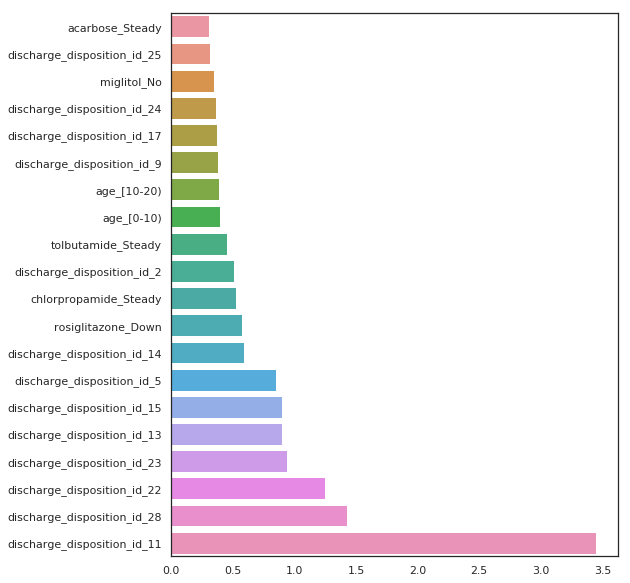

In [14]:
# Baseline: look at coefficient values
sns.set_style('white')
plt.figure(figsize=(8, 10))
idx = np.argsort(np.abs(modified_theta))[-20:]
sns.barplot(np.abs(modified_theta[idx]), X.columns.values[idx])

In [15]:
# Find children in the test set and see how predictions change on them
true_labels = Y_test[test_children_idx]

for i in range(len(test_children_idx)):
    if (orig_model_preds[i] < 0.5) != (modified_model_preds[i] < 0.5):
        print('*** ', end='')
    print("index %s, label %s: %s vs. %s" % (
        test_children_idx[i], true_labels[i], 
        orig_model_preds[i], modified_model_preds[i]))

index 473, label -1: 0.81592983 vs. 0.5582425
index 647, label -1: 0.84657747 vs. 0.61069316
index 1037, label -1: 0.79459083 vs. 0.52457315
index 1599, label -1: 0.7948243 vs. 0.5247949
index 1611, label -1: 0.8197187 vs. 0.5646979
*** index 1742, label -1: 0.739686 vs. 0.44726983
index 2119, label -1: 0.8280102 vs. 0.5777737
index 2623, label -1: 0.8021894 vs. 0.5360096
index 4901, label -1: 0.7773022 vs. 0.500649
index 6120, label -1: 0.8442046 vs. 0.6064186
index 6160, label -1: 0.8322884 vs. 0.58535564
index 6997, label -1: 0.8367686 vs. 0.5932293
index 7062, label -1: 0.80306506 vs. 0.53731537
index 7619, label -1: 0.83657545 vs. 0.59270567
index 9026, label -1: 0.8279446 vs. 0.5786623
index 9345, label -1: 0.8398102 vs. 0.59854573
index 9448, label -1: 0.8230917 vs. 0.57034266
index 10163, label -1: 0.8700594 vs. 0.65619683
index 10247, label -1: 0.8322668 vs. 0.5874941
index 10637, label -1: 0.8438151 vs. 0.60824984
index 11036, label -1: 0.8423663 vs. 0.60313493
index 11599, l

In [16]:
# Pick one of those children and find the most influential examples on it
test_idx = 1742
x_test = X_test[test_idx, :]
y_test = Y_test[test_idx]
print("Test point features:")
print(x_test)
print(y_test)
print('Younger than 10? %s' % x_test[age_var_indices[0]])

Test point features:
[ 1. 55.  0. 10.  0.  0.  1.  3.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  1.  0.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  1.]
-1
Younger than 10? 1.0


# Dissect get_influence_on_test_loss

In [17]:
import time
from scipy.optimize import fmin_ncg

In [18]:
def get_fmin_loss_fn(trained_model, v):

    def get_fmin_loss(x):
        print("get_fmin_loss")
        print("x", x)
        hessian_vector_val = minibatch_hessian_vector_val(trained_model, vec_to_list(x))
        print("hvp", hessian_vector_val)
        #print(len(hessian_vector_val))
        #print(len(hessian_vector_val[0]))
        print("v", v)
        return_val = 0.5 * np.dot(np.concatenate(hessian_vector_val), x) - np.dot(np.concatenate(v), x)
        print("fmin_loss", return_val)
        return return_val
    return get_fmin_loss


def get_fmin_grad_fn(trained_model, v):
    def get_fmin_grad(x):
        print("get_fmin_grad")
        hessian_vector_val = minibatch_hessian_vector_val(trained_model, vec_to_list(x))
        return_val = np.concatenate(hessian_vector_val) - np.concatenate(v)
        print("x", x)
        print("hvp", hessian_vector_val)
        print("v", v)
        print("fmin_grad", return_val)
        return return_val
    return get_fmin_grad

def get_cg_callback(trained_model, v, verbose):
    fmin_loss_fn = get_fmin_loss_fn(trained_model, v)

    def fmin_loss_split(x):
        hessian_vector_val = minibatch_hessian_vector_val(trained_model, vec_to_list(x))

        return 0.5 * np.dot(np.concatenate(hessian_vector_val), x), -np.dot(np.concatenate(v), x)

    def cg_callback(x):
        # x is current params
        v = trained_model.vec_to_list(x)
        idx_to_remove = 5

        single_train_feed_dict = trained_model.fill_feed_dict_with_one_ex(trained_model.data_sets.train, idx_to_remove)      
        train_grad_loss_val = trained_model.sess.run(trained_model.grad_total_loss_op, feed_dict=single_train_feed_dict)
        predicted_loss_diff = np.dot(np.concatenate(v), np.concatenate(train_grad_loss_val)) / trained_model.num_train_examples

        if verbose:
            print('Function value: %s' % fmin_loss_fn(x))
            quad, lin = fmin_loss_split(x)
            print('Split function value: %s, %s' % (quad, lin))
            print('Predicted loss diff on train_idx %s: %s' % (idx_to_remove, predicted_loss_diff))

    return cg_callback

def get_vec_to_list_fn(trained_model):
    params_val = trained_model.sess.run(trained_model.params)
    trained_model.num_params = len(np.concatenate(params_val))        
    print('Total number of parameters: %s' % trained_model.num_params)


    def vec_to_list(v):
        return_list = []
        cur_pos = 0
        for p in params_val:
            return_list.append(v[cur_pos : cur_pos+len(p)])
            cur_pos += len(p)

        assert cur_pos == len(v)
        return return_list

    return vec_to_list

    
def get_inverse_hvp_cg(trained_model, v, verbose=True):
    fmin_loss_fn = get_fmin_loss_fn(trained_model, v)
    fmin_grad_fn = get_fmin_grad_fn(trained_model, v)
    cg_callback = get_cg_callback(trained_model, v, verbose)

    fmin_results = fmin_ncg(
        f=fmin_loss_fn,
        x0=np.concatenate(v),
        fprime=fmin_grad_fn,
        fhess_p=trained_model.get_fmin_hvp,
        callback=cg_callback,
        avextol=1e-8,
        maxiter=100) 

    return vec_to_list(fmin_results)

In [19]:
def update_feed_dict_with_v_placeholder(trained_model, feed_dict, vec):
    for pl_block, vec_block in zip(trained_model.v_placeholder, vec):
        #print("pl_block", pl_block)
        #print("vec_block", vec_block)
        feed_dict[pl_block] = vec_block        
    return feed_dict


def minibatch_hessian_vector_val(trained_model, v):

    num_examples = trained_model.num_train_examples
    if trained_model.mini_batch == True:
        batch_size = 100
        assert num_examples % batch_size == 0
    else:
        batch_size = trained_model.num_train_examples

    num_iter = int(num_examples / batch_size)

    trained_model.reset_datasets()
    hessian_vector_val = None
    for i in range(num_iter):
        feed_dict = trained_model.fill_feed_dict_with_batch(trained_model.data_sets.train, batch_size=batch_size)
        #print("batch", feed_dict)
        # Can optimize this
        feed_dict = update_feed_dict_with_v_placeholder(trained_model, feed_dict, v)
        #print("v", feed_dict)
        hessian_vector_val_temp = trained_model.sess.run(trained_model.hessian_vector, feed_dict=feed_dict)
        if hessian_vector_val is None:
            hessian_vector_val = [b / float(num_iter) for b in hessian_vector_val_temp]
        else:
            hessian_vector_val = [a + (b / float(num_iter)) for (a,b) in zip(hessian_vector_val, hessian_vector_val_temp)]

    hessian_vector_val = [a + trained_model.damping * b for (a,b) in zip(hessian_vector_val, v)]

    return hessian_vector_val

In [27]:
def get_influence_on_test_loss(trained_model, test_indices, train_idx, 
    approx_type='cg', approx_params=None, force_refresh=True, test_description=None,
    loss_type='normal_loss',
    X=None, Y=None):
    # If train_idx is None then use X and Y (phantom points)
    # Need to make sure test_idx stays consistent between models
    # because mini-batching permutes dataset order

    if train_idx is None: 
        if (X is None) or (Y is None): raise ValueError('X and Y must be specified if using phantom points.')
        if X.shape[0] != len(Y): raise ValueError('X and Y must have the same length.')
    else:
        if (X is not None) or (Y is not None): raise ValueError('X and Y cannot be specified if train_idx is specified.')
    
    test_grad_loss_no_reg_val = trained_model.get_test_grad_loss_no_reg_val(test_indices, loss_type=loss_type)

    print('Norm of test gradient: %s' % np.linalg.norm(np.concatenate(test_grad_loss_no_reg_val)))

    start_time = time.time()

    if test_description is None:
        test_description = test_indices

    #approx_filename = os.path.join(trained_model.train_dir, '%s-%s-%s-test-%s.npz' % (self.model_name, approx_type, loss_type, test_description))
    #if os.path.exists(approx_filename) and force_refresh == False:
    #    inverse_hvp = list(np.load(approx_filename)['inverse_hvp'])
    #    print('Loaded inverse HVP from %s' % approx_filename)
    #else:
    inverse_hvp = get_inverse_hvp_cg(
        modified_model,
        test_grad_loss_no_reg_val# ,
        # approx_type,
        # approx_params
    )
    #    np.savez(approx_filename, inverse_hvp=inverse_hvp)
    #    print('Saved inverse HVP to %s' % approx_filename)
    np.save("inverse_hvp_tf.npy", inverse_hvp)
    duration = time.time() - start_time
    print('Inverse HVP took %s sec' % duration)


    print("Number of training examples", trained_model.num_train_examples)
    start_time = time.time()
    if train_idx is None:
        num_to_remove = len(Y)
        predicted_loss_diffs = np.zeros([num_to_remove])            
        for counter in np.arange(num_to_remove):
            single_train_feed_dict = trained_model.fill_feed_dict_manual(X[counter, :], [Y[counter]])      
            train_grad_loss_val = trained_model.sess.run(trained_model.grad_total_loss_op, feed_dict=single_train_feed_dict)
            predicted_loss_diffs[counter] = np.dot(np.concatenate(inverse_hvp), np.concatenate(train_grad_loss_val)) / trained_model.num_train_examples            

    else:            
        num_to_remove = len(train_idx)
        train_grad_loss_list = np.zeros([num_to_remove, 127])
        predicted_loss_diffs = np.zeros([num_to_remove])
        for counter, idx_to_remove in enumerate(train_idx):            
            single_train_feed_dict = trained_model.fill_feed_dict_with_one_ex(trained_model.data_sets.train, idx_to_remove)      
            train_grad_loss_val = trained_model.sess.run(trained_model.grad_total_loss_op, feed_dict=single_train_feed_dict)
            predicted_loss_diffs[counter] = np.dot(np.concatenate(inverse_hvp), np.concatenate(train_grad_loss_val)) / trained_model.num_train_examples
            # print(train_grad_loss_val[0])
            train_grad_loss_list[counter, :] = train_grad_loss_val[0]
    
    np.save("train_grad_tf.npy", train_grad_loss_list)
    print("train_grad_loss_list", train_grad_loss_list)
    duration = time.time() - start_time
    print('Multiplying by %s train examples took %s sec' % (num_to_remove, duration))

    return predicted_loss_diffs

In [28]:
# modified_model.sess.run(modified_model.v_placeholder)

In [29]:
vec_to_list = get_vec_to_list_fn(modified_model)

Total number of parameters: 127


In [30]:
# import cProfile

In [31]:
influences = get_influence_on_test_loss(modified_model,
                                        test_indices=[1742]
                                        ,train_idx=np.arange(len(modified_model.data_sets.train.labels))
                                        ,force_refresh=False
                                       )

Norm of test gradient: 31.066187
get_fmin_loss
x [ 0.55273014 30.400158    0.          5.5273013   0.          0.
  0.55273014  1.6581905   0.55273014  0.          0.          0.
  0.          0.          0.55273014  0.          0.          0.55273014
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.55273014  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.55273014  0.          0.          0.          0.55273014
  0.          0.          0.55273014  0.          0.          0.
  0.55273014  0.          0.          0.          0.55273014  0.
  0.          0.          0.55273014  0.          0.          0.
  0.55273014  0.          0.          0.          0.          0.55273014
  0.          0. 

Split function value: 251.00143432617188, -36.30379
Predicted loss diff on train_idx 5: -0.0005819025221052352
get_fmin_grad
x [-2.17606139e+00  2.07036591e+00 -7.67083704e-01 -4.08854055e+00
 -2.09751785e-01 -1.13620646e-01  1.49497986e-01 -2.54538321e+00
  2.58435100e-01 -2.53747433e-01  0.00000000e+00 -1.12863891e-02
 -1.03410542e-01 -3.42570595e-03  1.41777724e-01 -1.13495383e-02
 -7.61737861e-03  5.53542852e-01 -2.26486358e-03 -8.69776029e-03
 -2.06066519e-02 -5.01546487e-02 -8.80199969e-02 -1.21604063e-01
 -1.45641401e-01 -9.77265462e-02 -1.41398450e-02  2.51494318e-01
 -1.26901446e-02 -8.98451433e-02 -4.45017638e-03 -8.53490271e-03
 -7.96104521e-02 -3.44934571e-03 -6.16355741e-04 -2.69797689e-04
 -4.81839306e-05 -9.19770449e-04 -5.93010700e-05 -1.55758916e-03
 -1.62465370e-03 -7.02221354e-04  0.00000000e+00 -3.41144114e-05
 -2.19580717e-02  0.00000000e+00  0.00000000e+00 -1.27555178e-02
 -2.10742513e-03 -2.03803691e-04 -4.29485226e-03 -2.64118880e-05
 -1.04829168e-03 -6.01929519

get_fmin_loss
x [-1.3618071e+00  2.8654000e-01 -3.7279037e-01  3.0192336e-01
 -1.4553577e-01 -9.2566766e-02  2.5769699e-01 -1.6302423e+00
  3.3536813e-01 -2.1692611e-01  0.0000000e+00 -1.2310997e-02
 -9.9026464e-02 -4.0713111e-03  2.5299954e-01 -1.1722141e-02
 -7.4263127e-03  5.8513206e-01 -4.2486186e-03 -1.2729221e-02
 -2.3907650e-02 -4.7204066e-02 -6.8180919e-02 -8.8850103e-02
 -1.1638731e-01 -9.0238728e-02 -1.4944186e-02  2.8592125e-01
 -1.2512236e-02 -6.0437672e-02 -3.2153374e-03 -7.8667421e-03
 -4.7599148e-02 -4.4798134e-03 -4.8053564e-04 -3.2392761e-04
 -9.0132125e-05 -8.2947628e-04 -3.6964695e-05 -1.4635803e-03
 -1.5936194e-03 -4.5739513e-04  0.0000000e+00  5.0588846e-05
 -1.7065497e-02  0.0000000e+00  0.0000000e+00 -4.5418162e-03
 -6.9147610e-04 -3.4218225e-05 -2.6712755e-03 -1.8872017e-05
 -1.1201049e-03  5.8728177e-04 -2.0930329e-03  1.1866884e-01
  1.2766198e-03 -2.8635468e-02 -6.9555238e-02  2.5715998e-01
 -4.0526956e-02 -2.0588667e-03  1.8177620e-01 -5.6528885e-02
 -4.7469

get_fmin_loss
x [-1.36169922e+00  2.86518514e-01 -3.72705549e-01  3.01889002e-01
 -1.45518318e-01 -9.21056643e-02  2.57688254e-01 -1.63011289e+00
  3.38087112e-01 -2.15905473e-01  0.00000000e+00 -1.19029023e-02
 -9.87785384e-02 -4.24676621e-03  2.53463894e-01 -9.86501016e-03
 -6.48866780e-03  1.15442085e+00 -3.56189832e-02 -7.82355145e-02
 -9.33343917e-02 -1.13905549e-01 -1.35159612e-01 -1.55478865e-01
 -1.83205962e-01 -1.56392008e-01 -8.09099078e-02  2.86814213e-01
 -1.05170310e-02 -6.02755509e-02 -3.49750835e-03 -7.52707943e-03
 -4.71830480e-02 -6.36595348e-03  1.08245848e-04 -8.03914736e-04
 -2.05895078e-04 -4.25576261e-04  6.11885771e-05 -7.40132120e-04
 -3.06815235e-03  4.91348212e-04  0.00000000e+00  5.58732718e-04
 -1.56986862e-02  0.00000000e+00  0.00000000e+00 -3.73518025e-03
 -7.91129423e-06 -1.08405680e-03 -2.40068883e-03 -8.57181294e-05
 -2.22913572e-03  1.81360904e-03 -2.72143772e-03  1.18846759e-01
  4.24141530e-03 -2.77632661e-02 -6.84894770e-02  2.58571774e-01
 -4.01371

hvp [array([-2.59335667e-01,  3.02496567e+01,  1.37025356e-01,  5.89991093e+00,
        2.61600260e-02,  5.02768159e-02,  2.30678469e-01,  7.34492183e-01,
        1.71013817e-01,  6.66504577e-02,  0.00000000e+00,  1.24710575e-02,
        5.26026115e-02,  2.48752418e-03,  1.59027517e-01,  6.54114038e-03,
        4.53485083e-03,  7.99242500e-03,  8.62950180e-03,  1.59397908e-02,
        2.54563298e-02,  4.45981920e-02,  5.55011928e-02,  5.51605187e-02,
        2.30574645e-02,  2.50726193e-03, -1.17812515e-03,  2.57203192e-01,
        3.60917952e-03, -2.24612094e-02, -3.14009748e-03,  2.71742209e-03,
       -5.77822700e-03,  3.12978262e-03, -6.80484343e-04, -8.14422674e-06,
        8.57719206e-05,  4.59189876e-04, -8.14877694e-06, -4.60832729e-04,
        1.20168625e-04, -1.09542045e-03,  0.00000000e+00, -4.60581825e-04,
        7.67194061e-03,  0.00000000e+00,  0.00000000e+00, -1.97938946e-03,
       -6.87679567e-04,  1.94826120e-04, -1.29775167e-03,  6.44846514e-05,
        4.65917983e-

x [-1.2145368e+00  2.5722432e-01 -2.5701421e-01  2.5503546e-01
 -1.2171099e-01  5.3683800e-01  2.4577205e-01 -1.4535592e+00
  4.0468016e+00  1.1762438e+00  0.0000000e+00  5.4473728e-01
  2.3939231e-01 -2.4356785e-01  8.8684565e-01  2.5232618e+00
  1.2724588e+00  7.7766431e+02 -4.2824795e+01 -8.9428818e+01
 -9.4791405e+01 -9.1094719e+01 -9.1494102e+01 -9.1037117e+01
 -9.1323837e+01 -9.0389465e+01 -9.0058151e+01  1.5048120e+00
  2.7109427e+00  1.6085780e-01 -3.8837865e-01  4.5577294e-01
  5.2037728e-01 -2.5790610e+00  8.0320621e-01 -6.5550637e-01
 -1.5810655e-01  5.5049407e-01  1.3394225e-01  9.8604321e-01
 -2.0143311e+00  1.2945772e+00  0.0000000e+00  6.9366699e-01
  1.8486315e+00  0.0000000e+00  0.0000000e+00  1.0965163e+00
  9.3237448e-01 -1.4330640e+00  3.6667946e-01 -9.1263823e-02
 -1.5149472e+00  1.6745241e+00 -8.5986573e-01  3.6153334e-01
  4.0482225e+00  1.1619194e+00  1.3852038e+00  2.1842644e+00
  4.9158058e-01 -5.7954627e-01  4.6921401e+00  1.4811417e+00
 -3.7063900e-01  1.312

get_fmin_loss
x [-9.33572769e-01  2.01495200e-01 -5.06400943e-01  9.81972069e-02
  3.70205611e-01 -7.33793080e-01  1.61116064e-01 -1.82272708e+00
  1.82492390e+01  1.30110731e+01  0.00000000e+00  5.52537298e+00
  6.07557631e+00  5.01257372e+00  8.35931873e+00  2.42635250e+00
  3.85686302e+00  2.56412891e+03 -2.74536285e+02 -2.82191895e+02
 -2.83228302e+02 -2.86007355e+02 -2.85601440e+02 -2.84798889e+02
 -2.85699921e+02 -2.83520020e+02 -2.67286285e+02  3.69805622e+00
  1.14089966e-01 -1.14753664e+00  4.62983656e+00  3.37438560e+00
  1.08357978e+00  4.51047468e+00  2.65809345e+00 -1.52283800e+00
 -4.45102096e-01  1.92092180e+00  5.10252237e-01  2.31497049e+00
 -1.23979688e-01  3.75577927e+00  0.00000000e+00  2.39773941e+00
  4.85617685e+00  0.00000000e+00  0.00000000e+00 -1.87824488e-01
  2.07422352e+00 -4.26657438e+00  2.96377945e+00 -2.47791350e-01
 -1.65724385e+00  8.30609894e+00  1.06384373e+01  2.24490094e+00
  1.00714550e+01  9.99239159e+00  4.09767008e+00  1.08555784e+01
  6.31317

get_fmin_loss
x [-1.0273190e+00  1.8187815e-01 -3.5147476e-01  4.4260517e-02
 -5.4107440e-01 -5.3420484e-01  4.9121058e-01 -1.9527072e+00
  2.3119503e+01  1.7477299e+01  0.0000000e+00  1.1379986e+01
  3.1381698e+00  3.9558980e+00  8.5403605e+00  5.7152395e+00
  7.8508158e+00  3.5477500e+03 -3.2186414e+02 -4.0576599e+02
 -4.0370392e+02 -3.9774622e+02 -3.9613599e+02 -3.9809482e+02
 -3.9791376e+02 -3.9600610e+02 -3.8993488e+02  6.3570356e+00
  8.3835959e-01  1.6524659e+00  1.8418622e+00  8.6099730e+00
  5.5931702e+00 -4.5394692e+00  2.2012427e+00 -2.5438428e-01
 -4.8496577e-01  2.3074450e+00  9.4419593e-01  2.1152225e+00
  1.3454065e+00  3.0781364e+00  0.0000000e+00  3.4823809e+00
  1.6764455e+00  0.0000000e+00  0.0000000e+00  2.0947156e+00
  1.2525086e+00 -4.1744075e+00  3.4726193e+00 -2.0954321e-01
  1.3865372e+00  9.8159552e+00  1.2455622e+01  1.0278018e+01
  8.0297709e+00  9.4766979e+00  1.1584654e+00  1.6973398e+01
  1.2978573e+01  7.8103871e+00  1.2974368e+01  6.2252731e+00
  1.3573

get_fmin_loss
x [-6.9833475e-01  1.6869989e-01 -3.4536815e-01 -2.6350029e-02
 -5.6081629e-01 -9.9236643e-01  7.2140503e-01 -1.8080608e+00
  2.3301687e+01  1.7886501e+01  0.0000000e+00  6.1209922e+00
  7.0106173e+00  4.3259878e+00  1.0795662e+01  6.3136749e+00
  6.6050420e+00  3.5494260e+03 -3.3369092e+02 -3.9778317e+02
 -3.9337180e+02 -3.9739673e+02 -3.9779446e+02 -3.9825964e+02
 -3.9847745e+02 -3.9832187e+02 -3.9315399e+02  3.8879516e+00
  3.7359028e+00  1.3450643e+00  2.1884890e+00  4.8528543e+00
  2.1233847e+00 -1.8197553e+00  2.2685843e+00 -2.2708678e-01
 -4.7880259e-01  2.3293498e+00  9.5301563e-01  2.2243075e+00
  1.2035012e+00  3.1524634e+00  0.0000000e+00  3.5319903e+00
  5.3201022e+00  0.0000000e+00  0.0000000e+00  2.8818221e+00
  1.6401244e+00 -4.1497116e+00  3.0871558e+00 -2.0399690e-01
  1.3324277e+00  9.1210899e+00  9.0119591e+00  1.2845449e+01
  1.0192587e+01  1.3559086e+01  3.2950222e-01  1.6122969e+01
  1.1167415e+01  8.3046379e+00  1.3040168e+01  7.9107904e+00
  1.1919

get_fmin_loss
x [-7.46456325e-01  1.64497033e-01 -3.83392781e-01 -3.88027988e-02
 -4.92036760e-01 -1.15252256e+00  5.91204762e-01 -2.03366184e+00
  2.42213192e+01  1.81691647e+01  0.00000000e+00  6.79325199e+00
  5.49564457e+00  6.21860170e+00  9.40193176e+00  7.58730221e+00
  6.87923717e+00  3.55492114e+03 -3.59955200e+02 -3.91803802e+02
 -3.95192963e+02 -3.94394226e+02 -3.95114594e+02 -3.94702362e+02
 -3.95074493e+02 -3.95538177e+02 -3.90766998e+02  3.89488959e+00
  3.64584279e+00  1.84320176e+00  2.85159516e+00  1.79810953e+00
  2.99968004e+00  2.02201748e+00  2.42366219e+00 -1.51423633e-01
 -4.53375787e-01  2.39014316e+00  9.77015197e-01  2.44465208e+00
  1.13573289e+00  3.37656975e+00  0.00000000e+00  3.55211973e+00
  3.70032740e+00  0.00000000e+00  0.00000000e+00  2.57508636e+00
  2.37668347e+00 -4.07370853e+00  2.28724933e+00 -1.87807739e-01
  9.54236031e-01  1.03973141e+01  7.70153761e+00  1.31186743e+01
  1.11577578e+01  1.20011024e+01  1.51427031e+00  1.64142990e+01
  1.24525

get_fmin_loss
x [-7.57048368e-01  1.67559102e-01 -2.96477884e-01 -3.74776945e-02
 -4.57833707e-01 -9.16976869e-01  5.40985167e-01 -2.06979394e+00
  2.39461956e+01  1.84668732e+01  0.00000000e+00  6.60393143e+00
  5.89520216e+00  6.14634848e+00  9.67832947e+00  7.32586002e+00
  6.74893475e+00  3.55542871e+03 -3.60503021e+02 -3.92203522e+02
 -3.94194550e+02 -3.95004150e+02 -3.95083313e+02 -3.95195190e+02
 -3.95066223e+02 -3.95088440e+02 -3.90689423e+02  4.03358459e+00
  3.48442888e+00  2.03250670e+00  2.75680447e+00  2.01113415e+00
  3.22298408e+00  1.95482540e+00  2.42908812e+00 -1.48107409e-01
 -4.52082366e-01  2.38994718e+00  9.78870928e-01  2.44389415e+00
  1.11464679e+00  3.38415146e+00  0.00000000e+00  3.55725956e+00
  3.49219275e+00  0.00000000e+00  0.00000000e+00  2.36571193e+00
  2.37891793e+00 -4.06971550e+00  2.31647921e+00 -1.86634809e-01
  9.14107561e-01  1.04388590e+01  8.02770805e+00  1.25903111e+01
  1.13410769e+01  1.24809017e+01  1.21855354e+00  1.63790836e+01
  1.23263

get_fmin_loss
x [-7.53596008e-01  1.67429596e-01 -3.34760070e-01 -3.61275785e-02
 -4.77927744e-01 -9.13675010e-01  5.40100336e-01 -2.08075666e+00
  2.40308056e+01  1.85438576e+01  0.00000000e+00  6.66350842e+00
  5.97839880e+00  6.11122942e+00  9.76652145e+00  7.26957226e+00
  6.77209711e+00  3.56825391e+03 -3.64476624e+02 -3.93738373e+02
 -3.95003387e+02 -3.96019836e+02 -3.96133667e+02 -3.96152557e+02
 -3.96116364e+02 -3.96211121e+02 -3.91840393e+02  4.03535271e+00
  3.42651868e+00  2.02791476e+00  2.72034216e+00  2.21767950e+00
  3.20814252e+00  1.88221800e+00  2.53548789e+00 -5.14724702e-02
 -4.16280925e-01  2.42631531e+00  1.03242612e+00  2.54568028e+00
  9.34229076e-01  3.58715582e+00  0.00000000e+00  3.60975289e+00
  3.45579529e+00  0.00000000e+00  0.00000000e+00  2.24425936e+00
  2.43541145e+00 -3.93620372e+00  2.37229252e+00 -1.54460639e-01
  4.26339984e-01  1.04373569e+01  8.23467827e+00  1.26393995e+01
  1.12481565e+01  1.25710468e+01  1.22340643e+00  1.64177608e+01
  1.23561

get_fmin_loss
x [-7.49238908e-01  1.66900367e-01 -3.82195294e-01 -3.30970250e-02
 -5.16613960e-01 -8.97830963e-01  5.52897811e-01 -2.08048463e+00
  2.42791977e+01  1.87947578e+01  0.00000000e+00  6.72458029e+00
  6.20365810e+00  6.07425785e+00  9.98680496e+00  7.26493168e+00
  6.80546236e+00  3.59119019e+03 -3.69889252e+02 -3.96511597e+02
 -3.96765320e+02 -3.98101379e+02 -3.98318848e+02 -3.98176117e+02
 -3.98234955e+02 -3.98442596e+02 -3.93686127e+02  4.03429747e+00
  3.33988118e+00  1.95531535e+00  2.56288552e+00  2.68036127e+00
  3.16531181e+00  1.70159924e+00  2.64412355e+00  8.92918557e-02
 -3.45564008e-01  2.44579697e+00  1.13530135e+00  2.59829855e+00
  8.12393665e-01  3.76962399e+00  0.00000000e+00  3.70527077e+00
  3.47684598e+00  0.00000000e+00  0.00000000e+00  2.15262699e+00
  2.49022412e+00 -3.72847629e+00  2.41725111e+00 -8.97492915e-02
  5.32982051e-02  1.02970572e+01  8.79282665e+00  1.27051783e+01
  1.12707930e+01  1.27393465e+01  1.40135753e+00  1.64821453e+01
  1.24442

get_fmin_loss
x [-7.4859250e-01  1.6698824e-01 -3.8235605e-01 -3.2804526e-02
 -5.0756705e-01 -9.0444720e-01  5.4209650e-01 -2.0747881e+00
  2.4285355e+01  1.8797970e+01  0.0000000e+00  6.7251310e+00
  6.1906338e+00  6.0715709e+00  9.9714251e+00  7.2909088e+00
  6.8233395e+00  3.5914910e+03 -3.6887527e+02 -3.9645752e+02
 -3.9702075e+02 -3.9825406e+02 -3.9847165e+02 -3.9835864e+02
 -3.9842471e+02 -3.9861929e+02 -3.9393378e+02  4.0745611e+00
  3.4098635e+00  2.0287693e+00  2.3821602e+00  2.6404407e+00
  3.2468407e+00  1.6497982e+00  2.6210079e+00  7.9575799e-02
 -3.4135079e-01  2.4321105e+00  1.1396276e+00  2.5611303e+00
  8.4844118e-01  3.7205942e+00  0.0000000e+00  3.7072151e+00
  3.5095673e+00  0.0000000e+00  0.0000000e+00  2.2327688e+00
  2.4623113e+00 -3.7372417e+00  2.3308113e+00 -8.5768752e-02
  1.6319346e-01  1.0322506e+01  8.7222509e+00  1.2737594e+01
  1.1295619e+01  1.2859362e+01  1.3296930e+00  1.6472351e+01
  1.2417705e+01  9.8008614e+00  1.3607043e+01  8.9780798e+00
  1.0688

get_fmin_loss
x [-7.4864078e-01  1.6694492e-01 -3.8255647e-01 -3.2752998e-02
 -5.0729036e-01 -9.0481901e-01  5.4215622e-01 -2.0749404e+00
  2.4327543e+01  1.8847908e+01  0.0000000e+00  6.7347937e+00
  6.2063627e+00  6.0930476e+00  9.9900970e+00  7.3136287e+00
  6.8375969e+00  3.5925115e+03 -3.6902579e+02 -3.9651459e+02
 -3.9711975e+02 -3.9835275e+02 -3.9857733e+02 -3.9846252e+02
 -3.9852777e+02 -3.9872079e+02 -3.9403549e+02  4.0759993e+00
  3.4152772e+00  2.0298951e+00  2.4104047e+00  2.6186075e+00
  3.2439950e+00  1.6637292e+00  2.5967855e+00  6.5399632e-02
 -3.2168907e-01  2.4312892e+00  1.1587112e+00  2.5602965e+00
  8.6480671e-01  3.6829724e+00  0.0000000e+00  3.7170584e+00
  3.5137994e+00  0.0000000e+00  0.0000000e+00  2.2362473e+00
  2.4687371e+00 -3.7527862e+00  2.3405275e+00 -6.7515545e-02
  2.2621635e-01  1.0343301e+01  8.7471561e+00  1.2765450e+01
  1.1329697e+01  1.2884457e+01  1.3556893e+00  1.6497276e+01
  1.2441360e+01  9.8307590e+00  1.3630137e+01  9.0051060e+00
  1.0721

hvp [array([ 5.52691400e-01,  3.03996716e+01,  4.36023038e-06,  5.52711344e+00,
       -7.59445538e-06,  3.89159904e-05,  5.52726328e-01,  1.65823245e+00,
        5.53150356e-01, -4.80284216e-04,  0.00000000e+00,  2.64457194e-05,
        1.15806179e-04, -5.13618579e-06,  5.52546680e-01, -2.59002554e-05,
        1.11318659e-05,  5.52573860e-01,  6.34863973e-05, -1.44980848e-04,
       -9.17166471e-06, -6.54347241e-05,  1.47864223e-04,  8.64230096e-05,
        6.44661486e-05, -4.52771783e-05, -1.75088644e-06,  5.52662849e-01,
       -2.68383010e-05,  2.20965449e-05, -4.91004175e-05,  8.01114074e-05,
        1.18460783e-04, -2.47833959e-05,  8.67940253e-06,  3.54903113e-06,
       -2.47854405e-06,  1.77844777e-06, -2.74855120e-06,  2.61043897e-06,
       -1.15997027e-05,  1.47654500e-05,  0.00000000e+00, -1.35085429e-06,
       -5.36539883e-05,  0.00000000e+00,  0.00000000e+00, -1.82253571e-05,
       -5.90400305e-07,  3.51064955e-06, -1.99147617e-05, -2.42698434e-06,
       -3.57712488e-

hvp [array([ 5.52690566e-01,  3.03996658e+01,  4.20621291e-06,  5.52710915e+00,
       -7.63380376e-06,  3.88852568e-05,  5.52726209e-01,  1.65823197e+00,
        5.53150356e-01, -4.80369432e-04,  0.00000000e+00,  2.64429254e-05,
        1.15786388e-04, -5.13752457e-06,  5.52546620e-01, -2.59027001e-05,
        1.11297704e-05,  5.52573860e-01,  6.34863973e-05, -1.44984573e-04,
       -9.17539001e-06, -6.54533505e-05,  1.47875398e-04,  8.63783062e-05,
        6.44288957e-05, -4.52846289e-05, -1.75088644e-06,  5.52662730e-01,
       -2.68386502e-05,  2.20844377e-05, -4.91014507e-05,  8.01100687e-05,
        1.18446114e-04, -2.47844291e-05,  8.67940253e-06,  3.54902750e-06,
       -2.47854041e-06,  1.77812763e-06, -2.74855120e-06,  2.61043897e-06,
       -1.16003939e-05,  1.47657120e-05,  0.00000000e+00, -1.35085429e-06,
       -5.36560547e-05,  0.00000000e+00,  0.00000000e+00, -1.82267540e-05,
       -5.91098797e-07,  3.51064955e-06, -1.99219212e-05, -2.42697797e-06,
       -3.57715180e-

x [-7.48592675e-01  1.66988090e-01 -3.82356703e-01 -3.28043550e-02
 -5.07566154e-01 -9.04448450e-01  5.42096674e-01 -2.07478857e+00
  2.42854939e+01  1.87981339e+01  0.00000000e+00  6.72516298e+00
  6.19068575e+00  6.07164192e+00  9.97148705e+00  7.29098368e+00
  6.82338667e+00  3.59149438e+03 -3.68875763e+02 -3.96457703e+02
 -3.97021088e+02 -3.98254395e+02 -3.98471985e+02 -3.98358978e+02
 -3.98425049e+02 -3.98619629e+02 -3.93934113e+02  4.07456589e+00
  3.40988135e+00  2.02877307e+00  2.38225341e+00  2.64036870e+00
  3.24683142e+00  1.64984417e+00  2.62092805e+00  7.95290098e-02
 -3.41285914e-01  2.43210793e+00  1.13969052e+00  2.56112742e+00
  8.48495185e-01  3.72046995e+00  0.00000000e+00  3.70724750e+00
  3.50958133e+00  0.00000000e+00  0.00000000e+00  2.23278022e+00
  2.46233249e+00 -3.73729300e+00  2.33084345e+00 -8.57085064e-02
  1.63401470e-01  1.03225746e+01  8.72233295e+00  1.27376852e+01
  1.12957315e+01  1.28594446e+01  1.32977879e+00  1.64724331e+01
  1.24177828e+01  9.800

hvp [array([ 5.52706778e-01,  3.03998318e+01,  9.47330045e-06,  5.52717018e+00,
       -6.29558417e-06,  3.95272218e-05,  5.52729249e-01,  1.65825844e+00,
        5.53151250e-01, -4.78168018e-04,  0.00000000e+00,  2.65009585e-05,
        1.16211246e-04, -5.11138933e-06,  5.52549601e-01, -2.58141081e-05,
        1.11637637e-05,  5.52573919e-01,  6.34491444e-05, -1.44876540e-04,
       -8.82148743e-06, -6.53788447e-05,  1.46735460e-04,  8.83229077e-05,
        6.66864216e-05, -4.53330576e-05, -1.75833702e-06,  5.52665114e-01,
       -2.67491268e-05,  2.27347045e-05, -4.90644161e-05,  8.01246933e-05,
        1.18886324e-04, -2.47624557e-05,  8.67550261e-06,  3.55258362e-06,
       -2.47734351e-06,  1.78460323e-06, -2.74748891e-06,  2.62242975e-06,
       -1.15801449e-05,  1.47661776e-05,  0.00000000e+00, -1.34966103e-06,
       -5.34938008e-05,  0.00000000e+00,  0.00000000e+00, -1.81291107e-05,
       -5.77361789e-07,  3.50846676e-06, -1.98853522e-05, -2.42665419e-06,
       -3.57553799e-

hvp [array([ 5.52690566e-01,  3.03996658e+01,  4.20621291e-06,  5.52710915e+00,
       -7.63380376e-06,  3.88852568e-05,  5.52726209e-01,  1.65823197e+00,
        5.53150356e-01, -4.80369432e-04,  0.00000000e+00,  2.64429254e-05,
        1.15786854e-04, -5.13752457e-06,  5.52546620e-01, -2.59027001e-05,
        1.11297704e-05,  5.52573860e-01,  6.34863973e-05, -1.44984573e-04,
       -9.17539001e-06, -6.54533505e-05,  1.47875398e-04,  8.63783062e-05,
        6.44288957e-05, -4.52846289e-05, -1.75088644e-06,  5.52662730e-01,
       -2.68386502e-05,  2.20853690e-05, -4.91014507e-05,  8.01103597e-05,
        1.18446580e-04, -2.47844291e-05,  8.67940253e-06,  3.54902568e-06,
       -2.47853677e-06,  1.77812763e-06, -2.74855120e-06,  2.61043897e-06,
       -1.16003939e-05,  1.47657120e-05,  0.00000000e+00, -1.35085429e-06,
       -5.36560547e-05,  0.00000000e+00,  0.00000000e+00, -1.82267540e-05,
       -5.91098797e-07,  3.51064955e-06, -1.99218921e-05, -2.42697706e-06,
       -3.57715107e-

x [-7.48592675e-01  1.66988090e-01 -3.82356703e-01 -3.28043550e-02
 -5.07566154e-01 -9.04448450e-01  5.42096674e-01 -2.07478857e+00
  2.42854939e+01  1.87981339e+01  0.00000000e+00  6.72516298e+00
  6.19068575e+00  6.07164192e+00  9.97148705e+00  7.29098368e+00
  6.82338667e+00  3.59149438e+03 -3.68875763e+02 -3.96457703e+02
 -3.97021088e+02 -3.98254395e+02 -3.98471985e+02 -3.98358978e+02
 -3.98425049e+02 -3.98619629e+02 -3.93934113e+02  4.07456589e+00
  3.40988135e+00  2.02877307e+00  2.38225341e+00  2.64036870e+00
  3.24683142e+00  1.64984417e+00  2.62092805e+00  7.95290098e-02
 -3.41285884e-01  2.43210793e+00  1.13969052e+00  2.56112742e+00
  8.48495185e-01  3.72046995e+00  0.00000000e+00  3.70724750e+00
  3.50958133e+00  0.00000000e+00  0.00000000e+00  2.23278022e+00
  2.46233249e+00 -3.73729300e+00  2.33084345e+00 -8.57085064e-02
  1.63401484e-01  1.03225746e+01  8.72233295e+00  1.27376852e+01
  1.12957315e+01  1.28594446e+01  1.32977879e+00  1.64724331e+01
  1.24177828e+01  9.800

x [-7.48592675e-01  1.66988090e-01 -3.82356703e-01 -3.28043550e-02
 -5.07566154e-01 -9.04448450e-01  5.42096674e-01 -2.07478857e+00
  2.42854939e+01  1.87981339e+01  0.00000000e+00  6.72516298e+00
  6.19068575e+00  6.07164192e+00  9.97148705e+00  7.29098368e+00
  6.82338667e+00  3.59149438e+03 -3.68875763e+02 -3.96457703e+02
 -3.97021088e+02 -3.98254395e+02 -3.98471985e+02 -3.98358978e+02
 -3.98425049e+02 -3.98619629e+02 -3.93934113e+02  4.07456589e+00
  3.40988135e+00  2.02877307e+00  2.38225341e+00  2.64036870e+00
  3.24683142e+00  1.64984417e+00  2.62092805e+00  7.95290098e-02
 -3.41285884e-01  2.43210793e+00  1.13969052e+00  2.56112742e+00
  8.48495185e-01  3.72046995e+00  0.00000000e+00  3.70724750e+00
  3.50958133e+00  0.00000000e+00  0.00000000e+00  2.23278022e+00
  2.46233249e+00 -3.73729300e+00  2.33084345e+00 -8.57084990e-02
  1.63401484e-01  1.03225746e+01  8.72233295e+00  1.27376852e+01
  1.12957315e+01  1.28594446e+01  1.32977879e+00  1.64724331e+01
  1.24177828e+01  9.800

hvp [array([ 5.52692711e-01,  3.03996906e+01,  4.99143425e-06,  5.52711535e+00,
       -7.39218376e-06,  3.90243877e-05,  5.52726328e-01,  1.65823388e+00,
        5.53150594e-01, -4.79993527e-04,  0.00000000e+00,  2.64327973e-05,
        1.15823757e-04, -5.13839768e-06,  5.52547395e-01, -2.59059598e-05,
        1.11306435e-05,  5.52573860e-01,  6.35087490e-05, -1.44958496e-04,
       -9.23126936e-06, -6.55725598e-05,  1.48296356e-04,  8.70637596e-05,
        6.40116632e-05, -4.55081463e-05, -1.64285302e-06,  5.52663505e-01,
       -2.68363801e-05,  2.20594957e-05, -4.90918464e-05,  8.01100105e-05,
        1.18466836e-04, -2.47777061e-05,  8.68344796e-06,  3.54835447e-06,
       -2.47851494e-06,  1.77801121e-06, -2.74892227e-06,  2.60988600e-06,
       -1.15997100e-05,  1.47654209e-05,  0.00000000e+00, -1.35099981e-06,
       -5.36466541e-05,  0.00000000e+00,  0.00000000e+00, -1.82182557e-05,
       -5.90371201e-07,  3.51117342e-06, -1.99149072e-05, -2.42687111e-06,
       -3.57704776e-

x [-7.48592675e-01  1.66988090e-01 -3.82356703e-01 -3.28043550e-02
 -5.07566154e-01 -9.04448450e-01  5.42096674e-01 -2.07478857e+00
  2.42854939e+01  1.87981358e+01  0.00000000e+00  6.72516298e+00
  6.19068575e+00  6.07164192e+00  9.97148705e+00  7.29098415e+00
  6.82338667e+00  3.59149438e+03 -3.68875763e+02 -3.96457703e+02
 -3.97021088e+02 -3.98254395e+02 -3.98471985e+02 -3.98358978e+02
 -3.98425049e+02 -3.98619629e+02 -3.93934113e+02  4.07456589e+00
  3.40988135e+00  2.02877307e+00  2.38225365e+00  2.64036846e+00
  3.24683142e+00  1.64984417e+00  2.62092781e+00  7.95289278e-02
 -3.41285795e-01  2.43210793e+00  1.13969064e+00  2.56112742e+00
  8.48495305e-01  3.72046971e+00  0.00000000e+00  3.70724773e+00
  3.50958133e+00  0.00000000e+00  0.00000000e+00  2.23278022e+00
  2.46233249e+00 -3.73729324e+00  2.33084345e+00 -8.57084021e-02
  1.63401842e-01  1.03225746e+01  8.72233295e+00  1.27376862e+01
  1.12957315e+01  1.28594446e+01  1.32977891e+00  1.64724331e+01
  1.24177828e+01  9.800

hvp [array([ 5.52690566e-01,  3.03996658e+01,  4.20621291e-06,  5.52710915e+00,
       -7.63287244e-06,  3.88852568e-05,  5.52726209e-01,  1.65823197e+00,
        5.53150356e-01, -4.80369432e-04,  0.00000000e+00,  2.64429254e-05,
        1.15787785e-04, -5.13752457e-06,  5.52546620e-01, -2.59027001e-05,
        1.11297704e-05,  5.52573860e-01,  6.34863973e-05, -1.44984573e-04,
       -9.17539001e-06, -6.54496253e-05,  1.47879124e-04,  8.63783062e-05,
        6.44288957e-05, -4.52846289e-05, -1.75088644e-06,  5.52662730e-01,
       -2.68386502e-05,  2.20853690e-05, -4.91014507e-05,  8.01103306e-05,
        1.18446580e-04, -2.47844291e-05,  8.67943163e-06,  3.54902113e-06,
       -2.47852950e-06,  1.77812763e-06, -2.74854392e-06,  2.61043897e-06,
       -1.16003866e-05,  1.47657120e-05,  0.00000000e+00, -1.35085429e-06,
       -5.36560547e-05,  0.00000000e+00,  0.00000000e+00, -1.82267540e-05,
       -5.91098797e-07,  3.51064955e-06, -1.99218921e-05, -2.42697161e-06,
       -3.57708559e-

v [array([ 0.55273014, 30.400158  ,  0.        ,  5.5273013 ,  0.        ,
        0.        ,  0.55273014,  1.6581905 ,  0.55273014,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.55273014,
        0.        ,  0.        ,  0.55273014,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.55273014,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.55273014,  0.        ,  0.        ,  0.        ,  0.55273014,
        0.        ,  0.        ,  0.55273014,  0.        ,  0.        ,
        0.        ,  0.55273014,  0.        ,  0.        ,  0

x [-7.48592675e-01  1.66988090e-01 -3.82356703e-01 -3.28043550e-02
 -5.07566154e-01 -9.04448450e-01  5.42096674e-01 -2.07478857e+00
  2.42854939e+01  1.87981339e+01  0.00000000e+00  6.72516298e+00
  6.19068575e+00  6.07164192e+00  9.97148705e+00  7.29098368e+00
  6.82338667e+00  3.59149438e+03 -3.68875763e+02 -3.96457703e+02
 -3.97021088e+02 -3.98254395e+02 -3.98471985e+02 -3.98358978e+02
 -3.98425049e+02 -3.98619629e+02 -3.93934113e+02  4.07456589e+00
  3.40988135e+00  2.02877307e+00  2.38225341e+00  2.64036846e+00
  3.24683142e+00  1.64984417e+00  2.62092781e+00  7.95289651e-02
 -3.41285825e-01  2.43210793e+00  1.13969064e+00  2.56112742e+00
  8.48495245e-01  3.72046995e+00  0.00000000e+00  3.70724750e+00
  3.50958133e+00  0.00000000e+00  0.00000000e+00  2.23278022e+00
  2.46233249e+00 -3.73729300e+00  2.33084345e+00 -8.57084543e-02
  1.63401663e-01  1.03225746e+01  8.72233295e+00  1.27376852e+01
  1.12957315e+01  1.28594446e+01  1.32977879e+00  1.64724331e+01
  1.24177828e+01  9.800

hvp [array([ 5.52694678e-01,  3.03997040e+01,  5.51984340e-06,  5.52712297e+00,
       -7.23967969e-06,  3.90559217e-05,  5.52726805e-01,  1.65823781e+00,
        5.53150833e-01, -4.79874900e-04,  0.00000000e+00,  2.64610862e-05,
        1.15964678e-04, -5.13112172e-06,  5.52547455e-01, -2.58831424e-05,
        1.11446716e-05,  5.52573860e-01,  6.34863973e-05, -1.44939870e-04,
       -9.17166471e-06, -6.54272735e-05,  1.47923827e-04,  8.71270895e-05,
        6.44810498e-05, -4.52324748e-05, -1.75088644e-06,  5.52663565e-01,
       -2.68228177e-05,  2.21858063e-05, -4.90960956e-05,  8.01208080e-05,
        1.18559794e-04, -2.47773860e-05,  8.68030475e-06,  3.54931217e-06,
       -2.47852950e-06,  1.77897164e-06, -2.74854392e-06,  2.61233072e-06,
       -1.15995135e-05,  1.47666433e-05,  0.00000000e+00, -1.35085429e-06,
       -5.36225853e-05,  0.00000000e+00,  0.00000000e+00, -1.82063814e-05,
       -5.87548129e-07,  3.51184281e-06, -1.99185160e-05, -2.42697070e-06,
       -3.57698045e-

x [-7.48592675e-01  1.66988090e-01 -3.82356703e-01 -3.28043550e-02
 -5.07566154e-01 -9.04448450e-01  5.42096674e-01 -2.07478857e+00
  2.42854939e+01  1.87981339e+01  0.00000000e+00  6.72516298e+00
  6.19068575e+00  6.07164192e+00  9.97148705e+00  7.29098368e+00
  6.82338667e+00  3.59149438e+03 -3.68875763e+02 -3.96457703e+02
 -3.97021088e+02 -3.98254395e+02 -3.98471985e+02 -3.98358978e+02
 -3.98425049e+02 -3.98619629e+02 -3.93934113e+02  4.07456589e+00
  3.40988135e+00  2.02877307e+00  2.38225341e+00  2.64036846e+00
  3.24683142e+00  1.64984417e+00  2.62092781e+00  7.95289651e-02
 -3.41285825e-01  2.43210793e+00  1.13969064e+00  2.56112742e+00
  8.48495245e-01  3.72046995e+00  0.00000000e+00  3.70724750e+00
  3.50958133e+00  0.00000000e+00  0.00000000e+00  2.23278022e+00
  2.46233249e+00 -3.73729300e+00  2.33084345e+00 -8.57084468e-02
  1.63401678e-01  1.03225746e+01  8.72233295e+00  1.27376862e+01
  1.12957315e+01  1.28594446e+01  1.32977879e+00  1.64724331e+01
  1.24177828e+01  9.800

hvp [array([ 5.52694678e-01,  3.03997040e+01,  5.51984340e-06,  5.52712297e+00,
       -7.23967969e-06,  3.90559217e-05,  5.52726805e-01,  1.65823781e+00,
        5.53150833e-01, -4.79874900e-04,  0.00000000e+00,  2.64610862e-05,
        1.15964678e-04, -5.13112172e-06,  5.52547455e-01, -2.58831424e-05,
        1.11446716e-05,  5.52573860e-01,  6.34863973e-05, -1.44939870e-04,
       -9.17166471e-06, -6.54272735e-05,  1.47923827e-04,  8.71270895e-05,
        6.44810498e-05, -4.52324748e-05, -1.75088644e-06,  5.52663565e-01,
       -2.68228177e-05,  2.21858063e-05, -4.90960956e-05,  8.01208080e-05,
        1.18559794e-04, -2.47773860e-05,  8.68030475e-06,  3.54931217e-06,
       -2.47852950e-06,  1.77897164e-06, -2.74854392e-06,  2.61233072e-06,
       -1.15995135e-05,  1.47666433e-05,  0.00000000e+00, -1.35085429e-06,
       -5.36225853e-05,  0.00000000e+00,  0.00000000e+00, -1.82063814e-05,
       -5.87548129e-07,  3.51184281e-06, -1.99185160e-05, -2.42697070e-06,
       -3.57698045e-

x [-7.48592675e-01  1.66988090e-01 -3.82356703e-01 -3.28043550e-02
 -5.07566154e-01 -9.04448450e-01  5.42096674e-01 -2.07478857e+00
  2.42854939e+01  1.87981339e+01  0.00000000e+00  6.72516298e+00
  6.19068575e+00  6.07164192e+00  9.97148705e+00  7.29098368e+00
  6.82338667e+00  3.59149438e+03 -3.68875763e+02 -3.96457703e+02
 -3.97021088e+02 -3.98254395e+02 -3.98471985e+02 -3.98358978e+02
 -3.98425049e+02 -3.98619629e+02 -3.93934113e+02  4.07456589e+00
  3.40988135e+00  2.02877307e+00  2.38225341e+00  2.64036846e+00
  3.24683142e+00  1.64984417e+00  2.62092781e+00  7.95289651e-02
 -3.41285825e-01  2.43210793e+00  1.13969064e+00  2.56112742e+00
  8.48495245e-01  3.72046995e+00  0.00000000e+00  3.70724750e+00
  3.50958133e+00  0.00000000e+00  0.00000000e+00  2.23278022e+00
  2.46233249e+00 -3.73729300e+00  2.33084345e+00 -8.57084468e-02
  1.63401678e-01  1.03225746e+01  8.72233295e+00  1.27376862e+01
  1.12957315e+01  1.28594446e+01  1.32977879e+00  1.64724331e+01
  1.24177828e+01  9.800

hvp [array([ 5.52694678e-01,  3.03997040e+01,  5.51984340e-06,  5.52712297e+00,
       -7.23967969e-06,  3.90559217e-05,  5.52726805e-01,  1.65823781e+00,
        5.53150833e-01, -4.79874900e-04,  0.00000000e+00,  2.64610862e-05,
        1.15964678e-04, -5.13112172e-06,  5.52547455e-01, -2.58831424e-05,
        1.11446716e-05,  5.52573860e-01,  6.34863973e-05, -1.44939870e-04,
       -9.17166471e-06, -6.54272735e-05,  1.47923827e-04,  8.71270895e-05,
        6.44810498e-05, -4.52324748e-05, -1.75088644e-06,  5.52663565e-01,
       -2.68228177e-05,  2.21858063e-05, -4.90960956e-05,  8.01208080e-05,
        1.18559794e-04, -2.47773860e-05,  8.68030475e-06,  3.54931217e-06,
       -2.47852950e-06,  1.77897164e-06, -2.74854392e-06,  2.61233072e-06,
       -1.15995135e-05,  1.47666433e-05,  0.00000000e+00, -1.35085429e-06,
       -5.36225853e-05,  0.00000000e+00,  0.00000000e+00, -1.82063814e-05,
       -5.87548129e-07,  3.51184281e-06, -1.99185160e-05, -2.42697070e-06,
       -3.57698045e-

x [-7.48592675e-01  1.66988090e-01 -3.82356703e-01 -3.28043550e-02
 -5.07566154e-01 -9.04448450e-01  5.42096674e-01 -2.07478857e+00
  2.42854939e+01  1.87981339e+01  0.00000000e+00  6.72516298e+00
  6.19068575e+00  6.07164192e+00  9.97148705e+00  7.29098368e+00
  6.82338667e+00  3.59149438e+03 -3.68875763e+02 -3.96457703e+02
 -3.97021088e+02 -3.98254395e+02 -3.98471985e+02 -3.98358978e+02
 -3.98425049e+02 -3.98619629e+02 -3.93934113e+02  4.07456589e+00
  3.40988135e+00  2.02877307e+00  2.38225341e+00  2.64036846e+00
  3.24683142e+00  1.64984417e+00  2.62092781e+00  7.95289651e-02
 -3.41285825e-01  2.43210793e+00  1.13969064e+00  2.56112742e+00
  8.48495245e-01  3.72046995e+00  0.00000000e+00  3.70724750e+00
  3.50958133e+00  0.00000000e+00  0.00000000e+00  2.23278022e+00
  2.46233249e+00 -3.73729300e+00  2.33084345e+00 -8.57084468e-02
  1.63401678e-01  1.03225746e+01  8.72233295e+00  1.27376862e+01
  1.12957315e+01  1.28594446e+01  1.32977879e+00  1.64724331e+01
  1.24177828e+01  9.800

x [-7.48592675e-01  1.66988090e-01 -3.82356703e-01 -3.28043550e-02
 -5.07566154e-01 -9.04448450e-01  5.42096674e-01 -2.07478857e+00
  2.42854939e+01  1.87981339e+01  0.00000000e+00  6.72516298e+00
  6.19068575e+00  6.07164192e+00  9.97148705e+00  7.29098368e+00
  6.82338667e+00  3.59149438e+03 -3.68875763e+02 -3.96457703e+02
 -3.97021088e+02 -3.98254395e+02 -3.98471985e+02 -3.98358978e+02
 -3.98425049e+02 -3.98619629e+02 -3.93934113e+02  4.07456589e+00
  3.40988135e+00  2.02877307e+00  2.38225341e+00  2.64036846e+00
  3.24683142e+00  1.64984417e+00  2.62092781e+00  7.95289651e-02
 -3.41285825e-01  2.43210793e+00  1.13969064e+00  2.56112742e+00
  8.48495245e-01  3.72046995e+00  0.00000000e+00  3.70724750e+00
  3.50958133e+00  0.00000000e+00  0.00000000e+00  2.23278022e+00
  2.46233249e+00 -3.73729300e+00  2.33084345e+00 -8.57084468e-02
  1.63401678e-01  1.03225746e+01  8.72233295e+00  1.27376862e+01
  1.12957315e+01  1.28594446e+01  1.32977879e+00  1.64724331e+01
  1.24177828e+01  9.800

hvp [array([ 5.52696109e-01,  3.03997250e+01,  6.11274663e-06,  5.52712727e+00,
       -7.09852611e-06,  3.91000722e-05,  5.52727044e-01,  1.65824091e+00,
        5.53150833e-01, -4.79589566e-04,  0.00000000e+00,  2.64691189e-05,
        1.16021431e-04, -5.12937550e-06,  5.52547753e-01, -2.58779037e-05,
        1.11520058e-05,  5.52573860e-01,  6.34863973e-05, -1.44932419e-04,
       -9.17166471e-06, -6.54272735e-05,  1.47923827e-04,  8.74288380e-05,
        6.44959509e-05, -4.52324748e-05, -1.75088644e-06,  5.52663863e-01,
       -2.68107979e-05,  2.21977680e-05, -4.90931852e-05,  8.01253482e-05,
        1.18602402e-04, -2.47766293e-05,  8.68114876e-06,  3.54966141e-06,
       -2.47852950e-06,  1.77902984e-06, -2.74854392e-06,  2.61300011e-06,
       -1.15984076e-05,  1.47669925e-05,  0.00000000e+00, -1.35067967e-06,
       -5.36018342e-05,  0.00000000e+00,  0.00000000e+00, -1.82014919e-05,
       -5.86733222e-07,  3.51184281e-06, -1.99165952e-05, -2.42697070e-06,
       -3.57696008e-

Split function value: 1114.23486328125, -2228.8647
Predicted loss diff on train_idx 5: -6.420452434856732e-06
get_fmin_grad
x [-7.4860972e-01  1.6697276e-01 -3.8242766e-01 -3.2786116e-02
 -5.0746816e-01 -9.0458006e-01  5.4211783e-01 -2.0748425e+00
  2.4300430e+01  1.8815813e+01  0.0000000e+00  6.7285838e+00
  6.1962543e+00  6.0792451e+00  9.9780970e+00  7.2990270e+00
  6.8284340e+00  3.5918557e+03 -3.6892905e+02 -3.9647791e+02
 -3.9705612e+02 -3.9828931e+02 -3.9850940e+02 -3.9839575e+02
 -3.9846155e+02 -3.9865555e+02 -3.9397012e+02  4.0750751e+00
  3.4117980e+00  2.0291715e+00  2.3922527e+00  2.6326392e+00
  3.2458239e+00  1.6547761e+00  2.6123526e+00  7.4510299e-02
 -3.3432516e-01  2.4318171e+00  1.1464466e+00  2.5608325e+00
  8.5428900e-01  3.7071509e+00  0.0000000e+00  3.7107325e+00
  3.5110795e+00  0.0000000e+00  0.0000000e+00  2.2340117e+00
  2.4646075e+00 -3.7427962e+00  2.3342831e+00 -7.9246417e-02
  1.8571314e-01  1.0329936e+01  8.7311497e+00  1.2747547e+01
  1.1307796e+01  1.2

get_fmin_loss
x [-7.48640716e-01  1.66945502e-01 -3.82532090e-01 -3.27570476e-02
 -5.07300913e-01 -9.04838681e-01  5.42189717e-01 -2.07492757e+00
  2.43339176e+01  1.88541946e+01  0.00000000e+00  6.73787069e+00
  6.20823622e+00  6.09423208e+00  9.99192715e+00  7.31441545e+00
  6.83964062e+00  3.59251392e+03 -3.69025757e+02 -3.96512421e+02
 -3.97118469e+02 -3.98350891e+02 -3.98575653e+02 -3.98460785e+02
 -3.98526062e+02 -3.98718964e+02 -3.94032257e+02  4.07608652e+00
  3.41539645e+00  2.02927613e+00  2.40938544e+00  2.61794353e+00
  3.24412441e+00  1.66342199e+00  2.59777236e+00  6.61574528e-02
 -3.20467830e-01  2.43076086e+00  1.15951955e+00  2.55916977e+00
  8.65825653e-01  3.68353605e+00  0.00000000e+00  3.71731424e+00
  3.51443458e+00  0.00000000e+00  0.00000000e+00  2.23682380e+00
  2.46852970e+00 -3.75213623e+00  2.34190512e+00 -6.63484186e-02
  2.28399947e-01  1.03443937e+01  8.74781132e+00  1.27648382e+01
  1.13294153e+01  1.28851519e+01  1.35605049e+00  1.64978409e+01
  1.24428

hvp [array([ 5.52722335e-01,  3.04000244e+01,  6.83033795e-06,  5.52723932e+00,
       -3.09004827e-06,  2.59085500e-05,  5.52730203e-01,  1.65823781e+00,
        5.53003132e-01, -3.07958573e-04,  0.00000000e+00,  1.56195019e-05,
        7.57797970e-05, -2.72225589e-06,  5.52614093e-01, -1.51812565e-05,
        6.98707299e-06,  5.52629352e-01,  4.06652689e-05, -9.35345888e-05,
       -4.70876694e-06, -4.17381525e-05,  9.58554447e-05,  5.88335097e-05,
        4.26210463e-05, -2.82078981e-05, -5.19305468e-06,  5.52691221e-01,
       -1.70726271e-05,  1.80003117e-05, -3.05748981e-05,  5.23870403e-05,
        7.46294681e-05, -1.55519374e-05,  5.34986611e-06,  2.16536682e-06,
       -1.74371962e-06,  1.32163404e-06, -1.86972466e-06,  2.34006438e-06,
       -8.08596087e-06,  9.35769640e-06,  0.00000000e+00, -9.04110493e-07,
       -3.53129290e-05,  0.00000000e+00,  0.00000000e+00, -1.26097584e-05,
       -1.82044460e-07,  2.16485932e-06, -1.44006190e-05, -1.70003386e-06,
       -2.40002119e-

x [-7.4860972e-01  1.6697276e-01 -3.8242766e-01 -3.2786116e-02
 -5.0746816e-01 -9.0458006e-01  5.4211783e-01 -2.0748425e+00
  2.4300430e+01  1.8815813e+01  0.0000000e+00  6.7285838e+00
  6.1962543e+00  6.0792451e+00  9.9780970e+00  7.2990270e+00
  6.8284340e+00  3.5918557e+03 -3.6892905e+02 -3.9647791e+02
 -3.9705612e+02 -3.9828931e+02 -3.9850940e+02 -3.9839575e+02
 -3.9846155e+02 -3.9865555e+02 -3.9397012e+02  4.0750751e+00
  3.4117980e+00  2.0291715e+00  2.3922527e+00  2.6326392e+00
  3.2458239e+00  1.6547761e+00  2.6123526e+00  7.4510299e-02
 -3.3432516e-01  2.4318171e+00  1.1464466e+00  2.5608325e+00
  8.5428900e-01  3.7071509e+00  0.0000000e+00  3.7107325e+00
  3.5110795e+00  0.0000000e+00  0.0000000e+00  2.2340117e+00
  2.4646075e+00 -3.7427962e+00  2.3342831e+00 -7.9246417e-02
  1.8571314e-01  1.0329936e+01  8.7311497e+00  1.2747547e+01
  1.1307796e+01  1.2868329e+01  1.3389821e+00  1.6481256e+01
  1.2426158e+01  9.8115444e+00  1.3615295e+01  8.9877367e+00
  1.0700370e+01  5.353

hvp [array([ 5.52722335e-01,  3.04000244e+01,  6.83033795e-06,  5.52723932e+00,
       -3.09004827e-06,  2.59085500e-05,  5.52730203e-01,  1.65823781e+00,
        5.53003132e-01, -3.07958573e-04,  0.00000000e+00,  1.56195019e-05,
        7.57797970e-05, -2.72225589e-06,  5.52614093e-01, -1.51812565e-05,
        6.98707299e-06,  5.52629352e-01,  4.06652689e-05, -9.35345888e-05,
       -4.70876694e-06, -4.17381525e-05,  9.58554447e-05,  5.88335097e-05,
        4.26210463e-05, -2.82078981e-05, -5.19305468e-06,  5.52691221e-01,
       -1.70726271e-05,  1.80003117e-05, -3.05748981e-05,  5.23870403e-05,
        7.46294681e-05, -1.55519374e-05,  5.34986611e-06,  2.16536682e-06,
       -1.74371962e-06,  1.32163404e-06, -1.86972466e-06,  2.34006438e-06,
       -8.08596087e-06,  9.35769640e-06,  0.00000000e+00, -9.04110493e-07,
       -3.53129290e-05,  0.00000000e+00,  0.00000000e+00, -1.26097584e-05,
       -1.82044460e-07,  2.16485932e-06, -1.44006190e-05, -1.70003386e-06,
       -2.40002119e-

get_fmin_loss
x [-7.48609722e-01  1.66972756e-01 -3.82427663e-01 -3.27861123e-02
 -5.07468164e-01 -9.04580057e-01  5.42117834e-01 -2.07484245e+00
  2.43004322e+01  1.88158150e+01  0.00000000e+00  6.72858429e+00
  6.19625521e+00  6.07924604e+00  9.97809792e+00  7.29902792e+00
  6.82843494e+00  3.59185571e+03 -3.68929047e+02 -3.96477905e+02
 -3.97056122e+02 -3.98289307e+02 -3.98509399e+02 -3.98395752e+02
 -3.98461548e+02 -3.98655548e+02 -3.93970123e+02  4.07507515e+00
  3.41179824e+00  2.02917147e+00  2.39225388e+00  2.63263822e+00
  3.24582386e+00  1.65477669e+00  2.61235166e+00  7.45097399e-02
 -3.34324241e-01  2.43181705e+00  1.14644742e+00  2.56083250e+00
  8.54289770e-01  3.70714927e+00  0.00000000e+00  3.71073294e+00
  3.51107979e+00  0.00000000e+00  0.00000000e+00  2.23401189e+00
  2.46460772e+00 -3.74279690e+00  2.33428359e+00 -7.92455524e-02
  1.85716003e-01  1.03299370e+01  8.73115063e+00  1.27475481e+01
  1.13077974e+01  1.28683300e+01  1.33898330e+00  1.64812584e+01
  1.24261

x [-7.48609722e-01  1.66972756e-01 -3.82427663e-01 -3.27861160e-02
 -5.07468164e-01 -9.04580057e-01  5.42117834e-01 -2.07484245e+00
  2.43004322e+01  1.88158150e+01  0.00000000e+00  6.72858429e+00
  6.19625473e+00  6.07924557e+00  9.97809696e+00  7.29902744e+00
  6.82843447e+00  3.59185571e+03 -3.68929047e+02 -3.96477905e+02
 -3.97056122e+02 -3.98289307e+02 -3.98509399e+02 -3.98395752e+02
 -3.98461548e+02 -3.98655548e+02 -3.93970123e+02  4.07507515e+00
  3.41179824e+00  2.02917147e+00  2.39225316e+00  2.63263869e+00
  3.24582386e+00  1.65477633e+00  2.61235213e+00  7.45100155e-02
 -3.34324688e-01  2.43181705e+00  1.14644706e+00  2.56083250e+00
  8.54289353e-01  3.70715022e+00  0.00000000e+00  3.71073270e+00
  3.51107955e+00  0.00000000e+00  0.00000000e+00  2.23401165e+00
  2.46460772e+00 -3.74279642e+00  2.33428335e+00 -7.92459846e-02
  1.85714573e-01  1.03299370e+01  8.73115063e+00  1.27475481e+01
  1.13077965e+01  1.28683300e+01  1.33898270e+00  1.64812565e+01
  1.24261589e+01  9.811

hvp [array([ 5.52722394e-01,  3.04000244e+01,  6.85641498e-06,  5.52723932e+00,
       -3.08923336e-06,  2.59197259e-05,  5.52730203e-01,  1.65823781e+00,
        5.53003132e-01, -3.07943672e-04,  0.00000000e+00,  1.56202004e-05,
        7.57836387e-05, -2.72109173e-06,  5.52614093e-01, -1.51798595e-05,
        6.98800432e-06,  5.52629352e-01,  4.06652689e-05, -9.35345888e-05,
       -4.70504165e-06, -4.17381525e-05,  9.58554447e-05,  5.88409603e-05,
        4.26247716e-05, -2.82078981e-05, -5.19305468e-06,  5.52691281e-01,
       -1.70726271e-05,  1.80019415e-05, -3.05748981e-05,  5.23875060e-05,
        7.46303995e-05, -1.55519374e-05,  5.34986611e-06,  2.16536364e-06,
       -1.74371235e-06,  1.32163404e-06, -1.86972466e-06,  2.34006438e-06,
       -8.08595360e-06,  9.35769640e-06,  0.00000000e+00, -9.04110493e-07,
       -3.53123469e-05,  0.00000000e+00,  0.00000000e+00, -1.26097584e-05,
       -1.82044460e-07,  2.16485932e-06, -1.44006190e-05, -1.70003023e-06,
       -2.40001955e-

hvp [array([ 5.52723348e-01,  3.04000359e+01,  7.03802289e-06,  5.52724218e+00,
       -3.00518150e-06,  2.59662920e-05,  5.52730501e-01,  1.65823877e+00,
        5.53003252e-01, -3.07894312e-04,  0.00000000e+00,  1.56222959e-05,
        7.58232200e-05, -2.71969475e-06,  5.52614152e-01, -1.51742715e-05,
        6.99207885e-06,  5.52629352e-01,  4.06652689e-05, -9.35122371e-05,
       -4.70504165e-06, -4.16897237e-05,  9.58852470e-05,  5.88931143e-05,
        4.26322222e-05, -2.81594694e-05, -5.18932939e-06,  5.52691340e-01,
       -1.70706480e-05,  1.80441421e-05, -3.05744325e-05,  5.23900671e-05,
        7.46472797e-05, -1.55505841e-05,  5.34986611e-06,  2.16536046e-06,
       -1.74370871e-06,  1.32186688e-06, -1.86952093e-06,  2.34058825e-06,
       -8.08477489e-06,  9.35766730e-06,  0.00000000e+00, -9.04110493e-07,
       -3.53102514e-05,  0.00000000e+00,  0.00000000e+00, -1.26035884e-05,
       -1.80531060e-07,  2.16485932e-06, -1.43995712e-05, -1.70002568e-06,
       -2.39997753e-

fmin_loss -1114.6298828125
get_fmin_grad
x [-7.4860972e-01  1.6697276e-01 -3.8242766e-01 -3.2786116e-02
 -5.0746816e-01 -9.0458006e-01  5.4211783e-01 -2.0748425e+00
  2.4300430e+01  1.8815813e+01  0.0000000e+00  6.7285838e+00
  6.1962543e+00  6.0792451e+00  9.9780970e+00  7.2990270e+00
  6.8284340e+00  3.5918557e+03 -3.6892905e+02 -3.9647791e+02
 -3.9705612e+02 -3.9828931e+02 -3.9850940e+02 -3.9839575e+02
 -3.9846155e+02 -3.9865555e+02 -3.9397012e+02  4.0750751e+00
  3.4117980e+00  2.0291715e+00  2.3922529e+00  2.6326392e+00
  3.2458239e+00  1.6547762e+00  2.6123526e+00  7.4510232e-02
 -3.3432505e-01  2.4318171e+00  1.1464467e+00  2.5608325e+00
  8.5428911e-01  3.7071507e+00  0.0000000e+00  3.7107325e+00
  3.5110795e+00  0.0000000e+00  0.0000000e+00  2.2340117e+00
  2.4646075e+00 -3.7427962e+00  2.3342831e+00 -7.9246312e-02
  1.8571348e-01  1.0329936e+01  8.7311497e+00  1.2747547e+01
  1.1307796e+01  1.2868329e+01  1.3389822e+00  1.6481256e+01
  1.2426158e+01  9.8115444e+00  1.3615295e

x [-7.4860972e-01  1.6697276e-01 -3.8242766e-01 -3.2786116e-02
 -5.0746816e-01 -9.0458006e-01  5.4211783e-01 -2.0748425e+00
  2.4300430e+01  1.8815813e+01  0.0000000e+00  6.7285838e+00
  6.1962543e+00  6.0792451e+00  9.9780970e+00  7.2990270e+00
  6.8284340e+00  3.5918557e+03 -3.6892905e+02 -3.9647791e+02
 -3.9705612e+02 -3.9828931e+02 -3.9850940e+02 -3.9839575e+02
 -3.9846155e+02 -3.9865555e+02 -3.9397012e+02  4.0750751e+00
  3.4117980e+00  2.0291715e+00  2.3922529e+00  2.6326389e+00
  3.2458239e+00  1.6547762e+00  2.6123524e+00  7.4510232e-02
 -3.3432505e-01  2.4318171e+00  1.1464467e+00  2.5608325e+00
  8.5428911e-01  3.7071507e+00  0.0000000e+00  3.7107325e+00
  3.5110795e+00  0.0000000e+00  0.0000000e+00  2.2340117e+00
  2.4646075e+00 -3.7427962e+00  2.3342831e+00 -7.9246305e-02
  1.8571350e-01  1.0329936e+01  8.7311497e+00  1.2747547e+01
  1.1307796e+01  1.2868329e+01  1.3389822e+00  1.6481256e+01
  1.2426158e+01  9.8115444e+00  1.3615295e+01  8.9877367e+00
  1.0700370e+01  5.353

x [-7.4860972e-01  1.6697276e-01 -3.8242766e-01 -3.2786116e-02
 -5.0746816e-01 -9.0458006e-01  5.4211783e-01 -2.0748425e+00
  2.4300430e+01  1.8815813e+01  0.0000000e+00  6.7285838e+00
  6.1962543e+00  6.0792451e+00  9.9780970e+00  7.2990270e+00
  6.8284340e+00  3.5918557e+03 -3.6892905e+02 -3.9647791e+02
 -3.9705612e+02 -3.9828931e+02 -3.9850940e+02 -3.9839575e+02
 -3.9846155e+02 -3.9865555e+02 -3.9397012e+02  4.0750751e+00
  3.4117980e+00  2.0291715e+00  2.3922529e+00  2.6326389e+00
  3.2458239e+00  1.6547762e+00  2.6123524e+00  7.4510224e-02
 -3.3432505e-01  2.4318171e+00  1.1464467e+00  2.5608325e+00
  8.5428911e-01  3.7071507e+00  0.0000000e+00  3.7107325e+00
  3.5110795e+00  0.0000000e+00  0.0000000e+00  2.2340117e+00
  2.4646075e+00 -3.7427962e+00  2.3342831e+00 -7.9246297e-02
  1.8571353e-01  1.0329936e+01  8.7311497e+00  1.2747547e+01
  1.1307796e+01  1.2868329e+01  1.3389822e+00  1.6481256e+01
  1.2426158e+01  9.8115444e+00  1.3615295e+01  8.9877367e+00
  1.0700370e+01  5.353

hvp [array([ 5.5272162e-01,  3.0400015e+01,  6.7455876e-06,  5.5272365e+00,
       -3.1659511e-06,  2.5886780e-05,  5.5273008e-01,  1.6582370e+00,
        5.5300307e-01, -3.0800840e-04,  0.0000000e+00,  1.5618163e-05,
        7.5743999e-05, -2.7217902e-06,  5.5261397e-01, -1.5182421e-05,
        6.9884118e-06,  5.5262935e-01,  4.0665269e-05, -9.3519688e-05,
       -4.7273934e-06, -4.1734427e-05,  9.5885247e-05,  5.8811158e-05,
        4.2553991e-05, -2.8207898e-05, -5.1893294e-06,  5.5269116e-01,
       -1.7080893e-05,  1.8001825e-05, -3.0587369e-05,  5.2387390e-05,
        7.4602809e-05, -1.5552505e-05,  5.3496624e-06,  2.1653591e-06,
       -1.7437087e-06,  1.3212848e-06, -1.8697101e-06,  2.3397733e-06,
       -8.0856407e-06,  9.3572598e-06,  0.0000000e+00, -9.0411049e-07,
       -3.5321282e-05,  0.0000000e+00,  0.0000000e+00, -1.2607721e-05,
       -1.8233550e-07,  2.1648593e-06, -1.4412697e-05, -1.7000220e-06,
       -2.4000712e-05,  5.3520780e-06,  1.2209057e-06,  5.5271620e-01,
 

get_fmin_loss
x [-7.4860972e-01  1.6697276e-01 -3.8242766e-01 -3.2786116e-02
 -5.0746816e-01 -9.0458006e-01  5.4211783e-01 -2.0748425e+00
  2.4300430e+01  1.8815813e+01  0.0000000e+00  6.7285838e+00
  6.1962543e+00  6.0792451e+00  9.9780970e+00  7.2990270e+00
  6.8284340e+00  3.5918557e+03 -3.6892905e+02 -3.9647791e+02
 -3.9705612e+02 -3.9828931e+02 -3.9850940e+02 -3.9839575e+02
 -3.9846155e+02 -3.9865555e+02 -3.9397012e+02  4.0750751e+00
  3.4117980e+00  2.0291715e+00  2.3922529e+00  2.6326389e+00
  3.2458239e+00  1.6547762e+00  2.6123524e+00  7.4510224e-02
 -3.3432505e-01  2.4318171e+00  1.1464467e+00  2.5608325e+00
  8.5428911e-01  3.7071507e+00  0.0000000e+00  3.7107325e+00
  3.5110795e+00  0.0000000e+00  0.0000000e+00  2.2340117e+00
  2.4646075e+00 -3.7427962e+00  2.3342831e+00 -7.9246297e-02
  1.8571353e-01  1.0329936e+01  8.7311497e+00  1.2747547e+01
  1.1307796e+01  1.2868329e+01  1.3389822e+00  1.6481256e+01
  1.2426158e+01  9.8115444e+00  1.3615295e+01  8.9877367e+00
  1.0700

v [array([ 0.55273014, 30.400158  ,  0.        ,  5.5273013 ,  0.        ,
        0.        ,  0.55273014,  1.6581905 ,  0.55273014,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.55273014,
        0.        ,  0.        ,  0.55273014,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.55273014,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.55273014,  0.        ,  0.        ,  0.        ,  0.55273014,
        0.        ,  0.        ,  0.55273014,  0.        ,  0.        ,
        0.        ,  0.55273014,  0.        ,  0.        ,  0

x [-7.4860972e-01  1.6697276e-01 -3.8242766e-01 -3.2786116e-02
 -5.0746816e-01 -9.0458006e-01  5.4211783e-01 -2.0748425e+00
  2.4300430e+01  1.8815813e+01  0.0000000e+00  6.7285838e+00
  6.1962543e+00  6.0792451e+00  9.9780970e+00  7.2990270e+00
  6.8284340e+00  3.5918557e+03 -3.6892905e+02 -3.9647791e+02
 -3.9705612e+02 -3.9828931e+02 -3.9850940e+02 -3.9839575e+02
 -3.9846155e+02 -3.9865555e+02 -3.9397012e+02  4.0750751e+00
  3.4117980e+00  2.0291715e+00  2.3922529e+00  2.6326389e+00
  3.2458239e+00  1.6547762e+00  2.6123524e+00  7.4510224e-02
 -3.3432505e-01  2.4318171e+00  1.1464467e+00  2.5608325e+00
  8.5428911e-01  3.7071507e+00  0.0000000e+00  3.7107325e+00
  3.5110795e+00  0.0000000e+00  0.0000000e+00  2.2340117e+00
  2.4646075e+00 -3.7427962e+00  2.3342831e+00 -7.9246297e-02
  1.8571353e-01  1.0329936e+01  8.7311497e+00  1.2747547e+01
  1.1307796e+01  1.2868329e+01  1.3389822e+00  1.6481256e+01
  1.2426158e+01  9.8115444e+00  1.3615295e+01  8.9877367e+00
  1.0700370e+01  5.353

x [-7.4860972e-01  1.6697276e-01 -3.8242766e-01 -3.2786116e-02
 -5.0746816e-01 -9.0458006e-01  5.4211783e-01 -2.0748425e+00
  2.4300430e+01  1.8815813e+01  0.0000000e+00  6.7285838e+00
  6.1962543e+00  6.0792451e+00  9.9780970e+00  7.2990270e+00
  6.8284340e+00  3.5918557e+03 -3.6892905e+02 -3.9647791e+02
 -3.9705612e+02 -3.9828931e+02 -3.9850940e+02 -3.9839575e+02
 -3.9846155e+02 -3.9865555e+02 -3.9397012e+02  4.0750751e+00
  3.4117980e+00  2.0291715e+00  2.3922529e+00  2.6326389e+00
  3.2458239e+00  1.6547762e+00  2.6123524e+00  7.4510224e-02
 -3.3432505e-01  2.4318171e+00  1.1464467e+00  2.5608325e+00
  8.5428911e-01  3.7071507e+00  0.0000000e+00  3.7107325e+00
  3.5110795e+00  0.0000000e+00  0.0000000e+00  2.2340117e+00
  2.4646075e+00 -3.7427962e+00  2.3342831e+00 -7.9246297e-02
  1.8571353e-01  1.0329936e+01  8.7311497e+00  1.2747547e+01
  1.1307796e+01  1.2868329e+01  1.3389822e+00  1.6481256e+01
  1.2426158e+01  9.8115444e+00  1.3615295e+01  8.9877367e+00
  1.0700370e+01  5.353

hvp [array([ 5.5272162e-01,  3.0400015e+01,  6.7455876e-06,  5.5272365e+00,
       -3.1659511e-06,  2.5886780e-05,  5.5273008e-01,  1.6582370e+00,
        5.5300307e-01, -3.0800840e-04,  0.0000000e+00,  1.5618163e-05,
        7.5743999e-05, -2.7217902e-06,  5.5261397e-01, -1.5182421e-05,
        6.9884118e-06,  5.5262935e-01,  4.0665269e-05, -9.3519688e-05,
       -4.7273934e-06, -4.1734427e-05,  9.5885247e-05,  5.8811158e-05,
        4.2553991e-05, -2.8207898e-05, -5.1893294e-06,  5.5269116e-01,
       -1.7080893e-05,  1.8001825e-05, -3.0587369e-05,  5.2387390e-05,
        7.4602809e-05, -1.5552505e-05,  5.3496624e-06,  2.1653591e-06,
       -1.7437087e-06,  1.3212848e-06, -1.8697101e-06,  2.3397733e-06,
       -8.0856407e-06,  9.3572598e-06,  0.0000000e+00, -9.0411049e-07,
       -3.5321282e-05,  0.0000000e+00,  0.0000000e+00, -1.2607721e-05,
       -1.8233550e-07,  2.1648593e-06, -1.4412697e-05, -1.7000220e-06,
       -2.4000712e-05,  5.3520780e-06,  1.2209057e-06,  5.5271620e-01,
 

hvp [array([ 5.5272162e-01,  3.0400015e+01,  6.7455876e-06,  5.5272365e+00,
       -3.1659511e-06,  2.5886780e-05,  5.5273008e-01,  1.6582370e+00,
        5.5300307e-01, -3.0800840e-04,  0.0000000e+00,  1.5618163e-05,
        7.5743999e-05, -2.7217902e-06,  5.5261397e-01, -1.5182421e-05,
        6.9884118e-06,  5.5262935e-01,  4.0665269e-05, -9.3519688e-05,
       -4.7273934e-06, -4.1734427e-05,  9.5885247e-05,  5.8811158e-05,
        4.2553991e-05, -2.8207898e-05, -5.1893294e-06,  5.5269116e-01,
       -1.7080893e-05,  1.8001825e-05, -3.0587369e-05,  5.2387390e-05,
        7.4602809e-05, -1.5552505e-05,  5.3496624e-06,  2.1653591e-06,
       -1.7437087e-06,  1.3212848e-06, -1.8697101e-06,  2.3397733e-06,
       -8.0856407e-06,  9.3572598e-06,  0.0000000e+00, -9.0411049e-07,
       -3.5321282e-05,  0.0000000e+00,  0.0000000e+00, -1.2607721e-05,
       -1.8233550e-07,  2.1648593e-06, -1.4412697e-05, -1.7000220e-06,
       -2.4000712e-05,  5.3520780e-06,  1.2209057e-06,  5.5271620e-01,
 

x [-7.4860972e-01  1.6697276e-01 -3.8242766e-01 -3.2786116e-02
 -5.0746816e-01 -9.0458006e-01  5.4211783e-01 -2.0748425e+00
  2.4300430e+01  1.8815813e+01  0.0000000e+00  6.7285838e+00
  6.1962543e+00  6.0792451e+00  9.9780970e+00  7.2990270e+00
  6.8284340e+00  3.5918557e+03 -3.6892905e+02 -3.9647791e+02
 -3.9705612e+02 -3.9828931e+02 -3.9850940e+02 -3.9839575e+02
 -3.9846155e+02 -3.9865555e+02 -3.9397012e+02  4.0750751e+00
  3.4117980e+00  2.0291715e+00  2.3922529e+00  2.6326389e+00
  3.2458239e+00  1.6547762e+00  2.6123524e+00  7.4510224e-02
 -3.3432505e-01  2.4318171e+00  1.1464467e+00  2.5608325e+00
  8.5428911e-01  3.7071507e+00  0.0000000e+00  3.7107325e+00
  3.5110795e+00  0.0000000e+00  0.0000000e+00  2.2340117e+00
  2.4646075e+00 -3.7427962e+00  2.3342831e+00 -7.9246297e-02
  1.8571353e-01  1.0329936e+01  8.7311497e+00  1.2747547e+01
  1.1307796e+01  1.2868329e+01  1.3389822e+00  1.6481256e+01
  1.2426158e+01  9.8115444e+00  1.3615295e+01  8.9877367e+00
  1.0700370e+01  5.353

hvp [array([ 5.5272162e-01,  3.0400015e+01,  6.7455876e-06,  5.5272365e+00,
       -3.1659511e-06,  2.5886780e-05,  5.5273008e-01,  1.6582370e+00,
        5.5300307e-01, -3.0800840e-04,  0.0000000e+00,  1.5618163e-05,
        7.5743999e-05, -2.7217902e-06,  5.5261397e-01, -1.5182421e-05,
        6.9884118e-06,  5.5262935e-01,  4.0665269e-05, -9.3519688e-05,
       -4.7273934e-06, -4.1734427e-05,  9.5885247e-05,  5.8811158e-05,
        4.2553991e-05, -2.8207898e-05, -5.1893294e-06,  5.5269116e-01,
       -1.7080893e-05,  1.8001825e-05, -3.0587369e-05,  5.2387390e-05,
        7.4602809e-05, -1.5552505e-05,  5.3496624e-06,  2.1653591e-06,
       -1.7437087e-06,  1.3212848e-06, -1.8697101e-06,  2.3397733e-06,
       -8.0856407e-06,  9.3572598e-06,  0.0000000e+00, -9.0411049e-07,
       -3.5321282e-05,  0.0000000e+00,  0.0000000e+00, -1.2607721e-05,
       -1.8233550e-07,  2.1648593e-06, -1.4412697e-05, -1.7000220e-06,
       -2.4000712e-05,  5.3520780e-06,  1.2209057e-06,  5.5271620e-01,
 

hvp [array([ 5.5272162e-01,  3.0400015e+01,  6.7455876e-06,  5.5272365e+00,
       -3.1659511e-06,  2.5886780e-05,  5.5273008e-01,  1.6582370e+00,
        5.5300307e-01, -3.0800840e-04,  0.0000000e+00,  1.5618163e-05,
        7.5743999e-05, -2.7217902e-06,  5.5261397e-01, -1.5182421e-05,
        6.9884118e-06,  5.5262935e-01,  4.0665269e-05, -9.3519688e-05,
       -4.7273934e-06, -4.1734427e-05,  9.5885247e-05,  5.8811158e-05,
        4.2553991e-05, -2.8207898e-05, -5.1893294e-06,  5.5269116e-01,
       -1.7080893e-05,  1.8001825e-05, -3.0587369e-05,  5.2387390e-05,
        7.4602809e-05, -1.5552505e-05,  5.3496624e-06,  2.1653591e-06,
       -1.7437087e-06,  1.3212848e-06, -1.8697101e-06,  2.3397733e-06,
       -8.0856407e-06,  9.3572598e-06,  0.0000000e+00, -9.0411049e-07,
       -3.5321282e-05,  0.0000000e+00,  0.0000000e+00, -1.2607721e-05,
       -1.8233550e-07,  2.1648593e-06, -1.4412697e-05, -1.7000220e-06,
       -2.4000712e-05,  5.3520780e-06,  1.2209057e-06,  5.5271620e-01,
 

get_fmin_loss
x [-7.4860996e-01  1.6697253e-01 -3.8242853e-01 -3.2785881e-02
 -5.0746679e-01 -9.0458214e-01  5.4211843e-01 -2.0748432e+00
  2.4300703e+01  1.8816126e+01  0.0000000e+00  6.7286592e+00
  6.1963515e+00  6.0793672e+00  9.9782095e+00  7.2991524e+00
  6.8285251e+00  3.5918611e+03 -3.6892984e+02 -3.9647818e+02
 -3.9705664e+02 -3.9828979e+02 -3.9850995e+02 -3.9839627e+02
 -3.9846207e+02 -3.9865607e+02 -3.9397064e+02  4.0750833e+00
  3.4118273e+00  2.0291724e+00  2.3923922e+00  2.6325197e+00
  3.2458100e+00  1.6548464e+00  2.6122339e+00  7.4442342e-02
 -3.3421242e-01  2.4318085e+00  1.1465529e+00  2.5608189e+00
  8.5438287e-01  3.7069588e+00  0.0000000e+00  3.7107861e+00
  3.5111067e+00  0.0000000e+00  0.0000000e+00  2.2340345e+00
  2.4646394e+00 -3.7428722e+00  2.3343451e+00 -7.9141475e-02
  1.8606044e-01  1.0330053e+01  8.7312851e+00  1.2747688e+01
  1.1307971e+01  1.2868466e+01  1.3391210e+00  1.6481392e+01
  1.2426293e+01  9.8117027e+00  1.3615426e+01  8.9878902e+00
  1.0700

train_grad_loss_list [[ 2.42791247e+00  8.74048138e+00 -2.38215330e-06 ... -1.31399820e-05
  -5.37030974e-06  4.85599548e-01]
 [ 7.42033660e-01  2.30030155e+01 -2.38215330e-06 ... -1.31399820e-05
   3.71011019e-01  3.71033639e-01]
 [ 9.85112727e-01  1.67469006e+01 -2.38215330e-06 ... -1.31399820e-05
  -5.37030974e-06  4.92573172e-01]
 ...
 [ 4.98470974e+00  2.49235463e+00  2.07695961e+00 ... -1.31399820e-05
   4.15387034e-01  1.72417658e-05]
 [-1.20905924e+00 -1.51132526e+01 -2.38215330e-06 ... -1.31399820e-05
  -6.04535460e-01 -6.04512870e-01]
 [-1.66711497e+00 -3.83436661e+01 -2.38215330e-06 ... -1.31399820e-05
  -5.37030974e-06 -5.55688083e-01]]
Multiplying by 19980 train examples took 9.389318704605103 sec


In [25]:
influences[:10]

array([-2.23720348e-04,  2.62257191e-04,  1.24380515e-04, -4.11960575e-05,
       -3.70684329e-05, -6.42045243e-06, -5.05274027e-04, -3.06015473e-04,
        2.25382166e-04,  1.23777953e-04])

In [ ]:
len(modified_model.data_sets.train.labels)

# Continue with original code

In [ ]:
import numpy as np

In [32]:
top_k = 10
helpful_points = np.argsort(influences)[-top_k:][::-1]
unhelpful_points = np.argsort(influences)[:top_k]

influences_to_plot = []
ages_to_plot = []

for points, message in [
    (unhelpful_points, 'worse'), (helpful_points, 'better')]:
    print("Top %s training points making the loss on the test point %s:" % (top_k, message))
    for counter, idx in enumerate(points):
        print("#%5d, class=%s, age=%s, predicted_loss_diff=%.8f" % (
            idx,                 
            modified_Y_train[idx], 
            modified_X_train[idx, age_var_indices],
            influences[idx]))
        
        ages_to_plot.append(idx)
        influences_to_plot.append(influences[idx])


Top 10 training points making the loss on the test point worse:
#13685, class=1, age=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], predicted_loss_diff=-0.11919561
# 9366, class=1, age=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], predicted_loss_diff=-0.11769086
#11116, class=1, age=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], predicted_loss_diff=-0.08144067
# 5825, class=-1, age=[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], predicted_loss_diff=-0.00301897
#13027, class=1, age=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], predicted_loss_diff=-0.00257651
# 1912, class=1, age=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], predicted_loss_diff=-0.00200384
#15190, class=1, age=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], predicted_loss_diff=-0.00196439
#13061, class=1, age=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], predicted_loss_diff=-0.00171452
# 6890, class=1, age=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], predicted_loss_diff=-0.00168002
# 1132, class=1, age=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], predicted_loss_diff=-0.00158755
Top 10 training points making the loss on the test point better:
#19590, cl

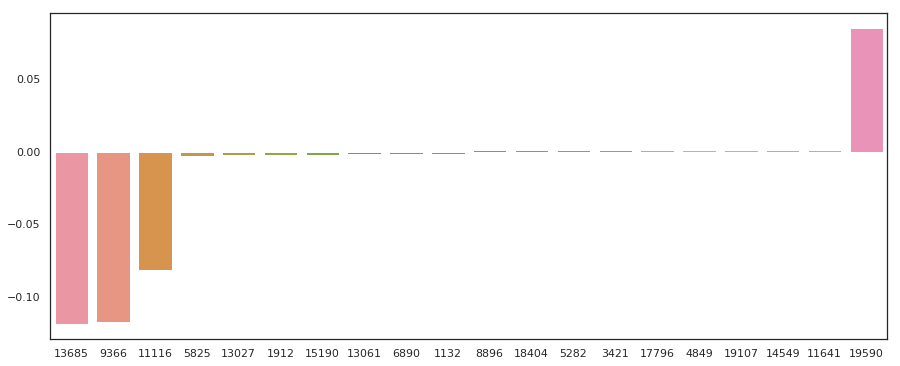

In [33]:
# The children in the modified dataset are by far the most influential
plt.figure(figsize=(15,6))
sort_idx = np.argsort(influences_to_plot)
ages_to_plot = np.array(ages_to_plot)
sns.barplot(ages_to_plot, influences_to_plot, order=ages_to_plot[sort_idx])

In [ ]:
￼influence: compare computed train_grad_loss
￼influence: compare used ndef get_grad_of_influence_wrt_input(trained_model, train_indices, test_indices, 
    approx_type='cg', approx_params=None, force_refresh=True, verbose=True, test_description=None,
    loss_type='normal_loss'):
    """
    If the loss goes up when you remove a point, then it was a helpful point.
    So positive influence = helpful.
    If we move in the direction of the gradient, we make the influence even more positive, 
    so even more helpful.
    Thus if we want to make the test point more wrong, we have to move in the opposite direction.
    """

    # Calculate v_placeholder (gradient of loss at test point)
    test_grad_loss_no_reg_val = trained_model.get_test_grad_loss_no_reg_val(test_indices, loss_type=loss_type)            

    if verbose: print('Norm of test gradient: %s' % np.linalg.norm(np.concatenate(test_grad_loss_no_reg_val)))

    start_time = time.time()

    if test_description is None:
        test_description = test_indices

    #approx_filename = os.path.join(trained_model.train_dir, '%s-%s-%s-test-%s.npz' % (trained_model.model_name, approx_type, loss_type, test_description))

    #if os.path.exists(approx_filename) and force_refresh == False:
    #    inverse_hvp = list(np.load(approx_filename)['inverse_hvp'])
    #    if verbose: print('Loaded inverse HVP from %s' % approx_filename)
    #else:            
    inverse_hvp = trained_model.get_inverse_hvp(
        test_grad_loss_no_reg_val,
        approx_type,
        approx_params,
        verbose=verbose)
    #np.savez(approx_filename, inverse_hvp=inverse_hvp)
    #if verbose: print('Saved inverse HVP to %s' % approx_filename)            

    duration = time.time() - start_time
    if verbose: print('Inverse HVP took %s sec' % duration)

    grad_influence_wrt_input_val = None

    for counter, train_idx in enumerate(train_indices):
        # Put in the train example in the feed dict
        grad_influence_feed_dict = trained_model.fill_feed_dict_with_one_ex(
            trained_model.data_sets.train,  
            train_idx)

        trained_model.update_feed_dict_with_v_placeholder(grad_influence_feed_dict, inverse_hvp)
        
        #print("grad_influence_feed_dict", trained_model.sess.run(grad_influence_feed_dict))
        
        # Run the grad op with the feed dict
        current_grad_influence_wrt_input_val = trained_model.sess.run(trained_model.grad_influence_wrt_input_op, feed_dict=grad_influence_feed_dict)[0][0, :]            

        if grad_influence_wrt_input_val is None:
            grad_influence_wrt_input_val = np.zeros([len(train_indices), len(current_grad_influence_wrt_input_val)])

        grad_influence_wrt_input_val[counter, :] = current_grad_influence_wrt_input_val

    return grad_influence_wrt_input_val

In [ ]:
# Look at which features are causing this influence
grad_influences_wrt_input_val = get_grad_of_influence_wrt_input(
    modified_model,
    [19590, 13685, 9366, 11116], 
    [test_idx], 
    force_refresh=False,
    test_description=None,
    loss_type='normal_loss')    

delta = grad_influences_wrt_input_val[0, :]
plt.figure(figsize=(8, 6))
idx_to_plot = np.array([0] * len(delta), dtype=bool)
idx_to_plot[:10] = 1
idx_to_plot[-10:] = 1
sns.barplot(np.sort(delta)[idx_to_plot], feature_names[np.argsort(delta)[idx_to_plot]], orient='h')

In [ ]:
approx_filename = 'output/diabetes_logreg-cg-normal_loss-test-[1742].npz'
inverse_hvp = list(np.load(approx_filename)['inverse_hvp'])
inverse_hvp

In [ ]:
grad_influences_wrt_input_val.shape